In [72]:
# change directory location if needed:    
data_dir = "/scratch/new_courier_pilot/" ## pilot data directory
# data_dir = "/scratch/EFRCourier_reports/" ## hospital data directory
time_window=10000 # you can chose how long do you want to visualize the data
exp = 'EFRCourierOpenLoop'
subject = 'R1620J' 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import numpy as np
import pandas as pd

def add_phase_column(evs):
    """Add phase column to events DataFrame"""
    evs["phase"] = 1
    new_evs = pd.DataFrame()  # Initialize as DataFrame, not list
    for ind, list_evs in evs.groupby('trial'):  # 'trial' is the equivalent of a delivery day
        list_evs = list_evs.copy()  # Avoid SettingWithCopyWarning
        if list_evs['trial'].unique()[0] != -999:
            list_evs['phase'] = 'nan'
            if not list_evs[list_evs['type'] == 'TRIAL_START'].index.empty and not list_evs[list_evs['type'] == 'TRIAL_END'].index.empty:
                # find indexes of encoding start and end
                rec_start_indices = list_evs[list_evs['type'] == 'REC_START'].index
                if not rec_start_indices.empty:
                    rec_start_index = rec_start_indices[0]
                    start_time = list_evs.loc[rec_start_index]['eegoffset']
                    # Find the actual start index based on time condition
                    i = 0
                    rec_start_index_found = True
                    actual_start_index = rec_start_index  # Initialize with default
                    
                    while rec_start_index_found:
                        current_idx = rec_start_index + i
                          #print(i)
                        # Check bounds for iloc access
                        check_time = evs.iloc[current_idx]['eegoffset']  # Use relative index i
                        if check_time - start_time < 3000:
                            i += 1
                            #print(check_time - start_time)
                        else:
                            rec_start_index_found = False
                            actual_start_index = rec_start_index+i
                            #print(i)# Get actual index from list_evs
                    rec_end_indices = list_evs[list_evs['type'] == 'REC_STOP'].index
                    if not rec_end_indices.empty:
                        rec_end_index = rec_end_indices[0]
                        # Now assign to original evs DataFrame using the original indices
                        evs.loc[actual_start_index:rec_end_index, 'phase'] = 'retrieval'
                        #print('get one value', actual_start_index,rec_end_index)
    return evs

# Get the full data index
whole_df = cml.CMLReader.get_data_index()

# Define the experiment
exp = 'EFRCourierOpenLoop'

# Get unique subjects for the experiment
subjects = whole_df.query('experiment == @exp')['subject'].unique()

# Initialize results storage
results = []

# Loop through each subject
for subject in subjects:
  #  print(f"Processing subject: {subject}")
    
    # Get subject data
    sub_df = whole_df.query('experiment == @exp and subject == @subject')
    
    # Get all sessions for this subject
    sessions = sub_df['session'].unique()
    
    # Loop through each session
    for session in sessions:
     #    print(f"  Processing session: {session}")
        
        try:
            # Create reader for this subject and session
            reader = cml.CMLReader(subject, exp, session=session)
            evs = reader.load('task_events')
            
            # Add the phase column
            evs = add_phase_column(evs)
            
            # Add the inside_stimuli variable
            evs['inside_stimuli'] = -999
            stimuli_indices = evs[evs['type'] == 'STIM'].index
            for i in stimuli_indices:
                current_offset = evs.loc[i, 'eegoffset']
                
                # Keep checking subsequent rows until difference >= 3000
                j = i + 1
                rows_to_assign = []  # Store indices of rows to assign
                
                while j < len(evs):
                    next_offset = evs.loc[j, 'eegoffset']
                    time_diff = abs(next_offset - current_offset)
                    
                    if time_diff < 3000:
                        # Still within 3 seconds, add this row to assignment list
                        rows_to_assign.append(j)
                        j += 1
                    else:
                        # Found a row with difference >= 4000, stop checking
                        break
                
                # Assign burst_freq to all rows that were within 4000ms of the STIM
                for row_idx in rows_to_assign:
                    evs.loc[row_idx, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
                    evs.loc[i, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
            # Get unique trials for this session
            trials = evs['trial'].unique()
# Find indices of all WORD events
            word_indices = evs[evs['type'] == "WORD"].index

            # Get the events immediately before WORD events
            preceding_events = evs.iloc[word_indices - 1]

            # Find which preceding events are STIM type
            stim_mask = preceding_events['type'] == 'STIM'
            stim_indices = preceding_events[stim_mask].index

            # Update the inside_stimuli column for WORD events that follow STIM events
            for stim_idx in stim_indices:
                word_idx = stim_idx + 1
                burst_freq = evs.loc[stim_idx, 'stim_params']['burst_freq']
                evs.loc[word_idx, 'inside_stimuli'] = burst_freq
                evs.loc[stim_idx, 'inside_stimuli'] = burst_freq
            # Loop through each trial
            for trial in trials:
                if trial != -999 and trial >= 0:  # Skip invalid trials   if trial != -999 and trial >= 0:
                   # print(f"    Processing trial: {trial}")
                    
                    # Filter events for this specific trial
                    trial_evs = evs[evs['trial'] == trial]
                    
                    # Filter for intrusions with additional conditions for this trial
                    intrusion_events = trial_evs[((trial_evs['intrusion'] > 0) | (trial_evs['intrusion'] == -1)) & 
                                                (trial_evs['type'] == 'REC_WORD') & 
                                                (trial_evs['phase'] == 'retrieval')]
                    none_intrusion_events = trial_evs[(trial_evs['intrusion'] == 0) & 
                                                     (trial_evs['type'] == 'REC_WORD') & 
                                                     (trial_evs['phase'] == 'retrieval')]
                    retrieval_phase_events=trial_evs[(trial_evs['phase'] == 'retrieval')]
                    encoding_phase_events=trial_evs[(trial_evs['phase'] != 'retrieval')]
                    # Count intrusions for each stimulation condition
                    intrusion_count_3hz = (intrusion_events['inside_stimuli'] == 3).sum()
                    intrusion_count_8hz = (intrusion_events['inside_stimuli'] == 8).sum()
                    intrusion_count_no_stim = (intrusion_events['inside_stimuli'] == -999).sum()
                    intrusion_count_total = len(intrusion_events)
                    stimi_retrieval_count_3hz = ((retrieval_phase_events['inside_stimuli'] == 3)&(trial_evs['type'] == 'STIM')).sum()
                    stimi_encoding_count_3hz = ((encoding_phase_events['inside_stimuli'] == 3)&(trial_evs['type'] == 'STIM')).sum()
                    stimi_retrieval_count_8hz = ((retrieval_phase_events['inside_stimuli'] == 8)&(trial_evs['type'] == 'STIM')).sum()
                    stimi_encoding_count_8hz = ((encoding_phase_events['inside_stimuli'] == 8)&(trial_evs['type'] == 'STIM')).sum()
                    # Count none intrusions for each stimulation condition
                    none_intrusion_count_3hz = (none_intrusion_events['inside_stimuli'] == 3).sum()
                    none_intrusion_count_8hz = (none_intrusion_events['inside_stimuli'] == 8).sum()
                    none_intrusion_count_no_stim = (none_intrusion_events['inside_stimuli'] == -999).sum()
                    none_intrusion_count_total = len(none_intrusion_events)
                  #  print(none_intrusion_events[['item','inside_stimuli']])
                    DuringSTIM_no=none_intrusion_events['inside_stimuli']==-999
                    No_stimuli_item=none_intrusion_events[DuringSTIM_no]['item']
                    DuringSTIM_yes=(none_intrusion_events['inside_stimuli']==3)|(none_intrusion_events['inside_stimuli']==8)
                    With_stimuli_item=none_intrusion_events[DuringSTIM_yes]['item']
                    Encode_withStimulation_item=trial_evs[(trial_evs['type']=='WORD') & ( (trial_evs['inside_stimuli']==3)| (trial_evs['inside_stimuli']==8))]['item']
                    Encode_without_Stimulation_item=trial_evs[(trial_evs['type']=='WORD') & (trial_evs['inside_stimuli']==-999)]['item']
                    # Convert to sets for efficient intersection operations
                    with_stimuli_set = set(With_stimuli_item)
                    encode_with_stim_set = set(Encode_withStimulation_item)
                    encode_without_stim_set = set(Encode_without_Stimulation_item)
                    no_stimuli_set = set(No_stimuli_item)

                    # Calculate overlaps for With_stimuli_item
                    with_stim_from_encode_with = len(with_stimuli_set.intersection(encode_with_stim_set))
                    with_stim_from_encode_without = len(with_stimuli_set.intersection(encode_without_stim_set))

                    # Calculate overlaps for No_stimuli_item  
                    no_stim_from_encode_with = len(no_stimuli_set.intersection(encode_with_stim_set))
                    no_stim_from_encode_without = len(no_stimuli_set.intersection(encode_without_stim_set))
                    # Store results for this trial
                    trial_result = {
                                'subject': subject,
                                'session': session,
                                'trial': trial,
                                'intrusion_count_3hz': intrusion_count_3hz if  (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'intrusion_count_8hz': intrusion_count_8hz if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'intrusion_count_no_stim': intrusion_count_no_stim,
                                'intrusion_count_total': intrusion_count_total,
                                'none_intrusion_count_3hz': none_intrusion_count_3hz if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'none_intrusion_count_8hz': none_intrusion_count_8hz if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'none_intrusion_count_no_stim': none_intrusion_count_no_stim,
                                'none_intrusion_count_total': none_intrusion_count_total,
                                'relative_intrusion_3hz': intrusion_count_3hz - intrusion_count_no_stim if intrusion_count_3hz != 0 else None, 
                                'relative_intrusion_8hz': intrusion_count_8hz - intrusion_count_no_stim if intrusion_count_8hz != 0 else None,
                                'relative_recall_3hz': none_intrusion_count_3hz - none_intrusion_count_no_stim if none_intrusion_count_3hz != 0 else None,
                                'relative_recall_8hz': none_intrusion_count_8hz - none_intrusion_count_no_stim if none_intrusion_count_8hz != 0 else None,
                                'encode_STIM_retrival_STIM_8hz':with_stim_from_encode_with if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'encode_No_retrival_STIM_8hz':with_stim_from_encode_without if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'encode_STIM_retrival_No_8hz':no_stim_from_encode_with if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'encode_No_retrival_No_8hz':no_stim_from_encode_without if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'encode_STIM_retrival_STIM_3hz':with_stim_from_encode_with if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'encode_No_retrival_STIM_3hz':with_stim_from_encode_without if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'encode_STIM_retrival_No_3hz':no_stim_from_encode_with if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'encode_No_retrival_No_3hz':no_stim_from_encode_without if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'stimi_retrieval_count_3hz':stimi_retrieval_count_3hz,
                                'stimi_retrieval_count_8hz':stimi_retrieval_count_8hz,
                                'stimi_encoding_count_3hz':stimi_encoding_count_3hz,
                                'stimi_encoding_count_8hz':stimi_encoding_count_8hz,
                        
                        
                            }
                    results.append(trial_result)
                    
                  #  print(f"      Trial {trial} - Intrusions - 3Hz: {intrusion_count_3hz}, 8Hz: {intrusion_count_8hz}, No stim: {intrusion_count_no_stim}, Total: {intrusion_count_total}")
            
        except Exception as e:
          #  print(f"    Error processing session {session}: {str(e)}")
            continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display summary statistics
print("\n" + "="*50)
print("INTRUSION ANALYSIS SUMMARY (BY TRIAL)")
print("="*50)

if len(results_df) > 0:
    print(f"Total subjects processed: {results_df['subject'].nunique()}")
    print(f"Total sessions processed: {results_df['session'].nunique()}")
    print(f"Total trials processed: {len(results_df)}")
    print(f"\nIntrusion statistics across all trials:")
    print(f"Mean intrusions per trial:")
    print(f"  3Hz stimulation: {results_df['intrusion_count_3hz'].mean():.3f} ± {results_df['intrusion_count_3hz'].std():.3f}")
    print(f"  8Hz stimulation: {results_df['intrusion_count_8hz'].mean():.3f} ± {results_df['intrusion_count_8hz'].std():.3f}")
    print(f"  No stimulation: {results_df['intrusion_count_no_stim'].mean():.3f} ± {results_df['intrusion_count_no_stim'].std():.3f}")
    print(f"  Total: {results_df['intrusion_count_total'].mean():.3f} ± {results_df['intrusion_count_total'].std():.3f}")
    print(f"\nTotal intrusions across all trials:")
    print(f"  3Hz stimulation: {results_df['intrusion_count_3hz'].sum()}")
    print(f"  8Hz stimulation: {results_df['intrusion_count_8hz'].sum()}")
    print(f"  No stimulation: {results_df['intrusion_count_no_stim'].sum()}")
    print(f"  Total: {results_df['intrusion_count_total'].sum()}")
    
    # Display the results DataFrame
    print(f"\nDetailed results:")
  



INTRUSION ANALYSIS SUMMARY (BY TRIAL)
Total subjects processed: 7
Total sessions processed: 5
Total trials processed: 66

Intrusion statistics across all trials:
Mean intrusions per trial:
  3Hz stimulation: 0.600 ± 1.006
  8Hz stimulation: 0.405 ± 0.599
  No stimulation: 0.833 ± 1.046
  Total: 1.379 ± 1.390

Total intrusions across all trials:
  3Hz stimulation: 21.0
  8Hz stimulation: 15.0
  No stimulation: 55
  Total: 91

Detailed results:


In [77]:
 evs[evs['trial']==1]

,eegoffset,correctPointingDirection,eegfile,efr_mark,experiment,finalrecalled,intruded,intrusion,item,itemno,...,session,stim_params,store,storeX,storeZ,subject,submittedPointingDirection,trial,type,inside_stimuli
141,1543871,-999.000000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",florist,36.750000,59.062500,R1724J,-999.000,1,pointing begins,-999
142,1543871,-999.000000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,-999.000000,-999.000000,R1724J,-999.000,1,TRIAL_START,-999
143,1553088,151.125000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,36.750000,59.062500,R1724J,243.000,1,pointing finished,-999
144,1566370,-999.000000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,-999.000000,-999.000000,R1724J,-999.000,1,POINTER_ON,-999
145,1604062,-999.000000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,CHRYSANTHEMUM,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",florist,14.492188,-33.750000,R1724J,-999.000,1,WORD,-999
146,1605987,-999.000000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",pizzeria,14.492188,-33.750000,R1724J,-999.000,1,pointing begins,-999
147,1616646,270.500000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,14.492188,-33.750000,R1724J,329.250,1,pointing finished,-999
148,1625477,-999.000000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 0, 'amplitude': 0.7001953125, 'ano...",-999,-999.000000,-999.000000,R1724J,-999.000,1,STIM,8
149,1626283,-999.000000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,ANCHOVIES,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",pizzeria,-29.562500,-37.250000,R1724J,-999.000,1,WORD,8
150,1628292,-999.000000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",hardware store,-29.562500,-37.250000,R1724J,-999.000,1,pointing begins,8


In [73]:
results_df

,subject,session,trial,intrusion_count_3hz,intrusion_count_8hz,intrusion_count_no_stim,intrusion_count_total,none_intrusion_count_3hz,none_intrusion_count_8hz,none_intrusion_count_no_stim,...,encode_STIM_retrival_No_8hz,encode_No_retrival_No_8hz,encode_STIM_retrival_STIM_3hz,encode_No_retrival_STIM_3hz,encode_STIM_retrival_No_3hz,encode_No_retrival_No_3hz,stimi_retrieval_count_3hz,stimi_retrieval_count_8hz,stimi_encoding_count_3hz,stimi_encoding_count_8hz
0,FBG490,0,0,NaN,0.0,2,2,NaN,1.0,4,...,3.0,1.0,NaN,NaN,NaN,NaN,0,1,0,6
1,FBG490,0,1,0.0,NaN,0,0,1.0,NaN,7,...,NaN,NaN,1.0,0.0,2.0,4.0,2,0,6,0
2,FBG490,0,2,NaN,0.0,2,2,NaN,2.0,5,...,2.0,3.0,NaN,NaN,NaN,NaN,0,2,0,5
3,FBG490,0,3,0.0,NaN,0,0,2.0,NaN,9,...,NaN,NaN,0.0,2.0,5.0,3.0,2,0,6,0
4,FBG490,0,4,0.0,1.0,1,2,0.0,1.0,6,...,3.0,3.0,0.0,1.0,3.0,3.0,0,2,6,8
5,FBG490,1,0,NaN,0.0,2,2,NaN,2.0,7,...,2.0,5.0,NaN,NaN,NaN,NaN,0,3,0,5
6,FBG490,1,1,0.0,NaN,1,1,1.0,NaN,10,...,NaN,NaN,1.0,0.0,2.0,7.0,2,0,5,0
7,FBG490,1,2,NaN,1.0,0,1,NaN,1.0,7,...,3.0,4.0,NaN,NaN,NaN,NaN,0,3,0,5
8,FBG490,1,3,0.0,NaN,1,1,2.0,NaN,5,...,NaN,NaN,1.0,1.0,2.0,3.0,2,0,6,0
9,FBG490,1,4,0.0,0.0,4,4,0.0,2.0,6,...,3.0,3.0,1.0,1.0,3.0,3.0,0,3,7,5


In [74]:
results_df_new=results_df.groupby(['subject', 'session']).sum()
results_df_new

trial  intrusion_count_3hz  intrusion_count_8hz  \
subject session                                                    
FBG490  0           10                  0.0                  1.0   
        1           10                  0.0                  1.0   
        2           10                  0.0                  1.0   
FBG491  1           10                  4.0                  3.0   
        2           10                  1.0                  0.0   
R1620J  3           10                  2.0                  3.0   
        4           10                  4.0                  1.0   
R1653J  0            6                  0.0                  1.0   
        1           10                  0.0                  1.0   
        2           10                  1.0                  1.0   
R1693J  0            6                  4.0                  1.0   
        1            1                  0.0                  0.0   
R1709J  0            6                  1.0                  0.0   
        1            3                  0.0                  0.0   
R1724J  0            6                  4.0                  1.0   

                 intrusion_count_no_stim  intrusion_count_total  \
subject session                                                   
FBG490  0                              5                      6   
        1                              8                      9   
        2                              8                      9   
FBG491  1                             10                     17   
        2                             10                     11   
R1620J  3                              0                      5   
        4                              2                      7   
R1653J  0                              1                      2   
        1                              3                      4   
        2                              0                      2   
R1693J  0                              3                      8   
        1                              1                      1   
R1709J  0                              2                      3   
        1                              0                      0   
R1724J  0                              2                      7   

                 none_intrusion_count_3hz  none_intrusion_count_8hz  \
subject session                                                       
FBG490  0                             3.0                       4.0   
        1                             3.0                       5.0   
        2                             4.0                      10.0   
FBG491  1                             5.0                       3.0   
        2                             4.0                       4.0   
R1620J  3                             8.0                       3.0   
        4                            10.0                       2.0   
R1653J  0                             1.0                       5.0   
        1                             3.0                       5.0   
        2                             5.0                       1.0   
R1693J  0                             0.0                       0.0   
        1                             4.0                       1.0   
R1709J  0                             9.0                       3.0   
        1                             2.0                       2.0   
R1724J  0                             2.0                       6.0   

                 none_intrusion_count_no_stim  none_intrusion_count_total  \
subject session                                                             
FBG490  0                                  31                          38   
        1                                  35                          43   
        2                                  30                          44   
FBG491  1                                  22                          30   
        2                                  25     

In [59]:
results_df_new

In [53]:
pd.set_option('display.max_rows', None)
print(results_df['stimi_encoding_count_8hz'].sum())
print(results_df['stimi_encoding_count_3hz'].sum())
print(results_df['stimi_retrieval_count_3hz'].sum())
print(results_df['stimi_retrieval_count_8hz'].sum())
len(results_df)

246
265
115
89


66

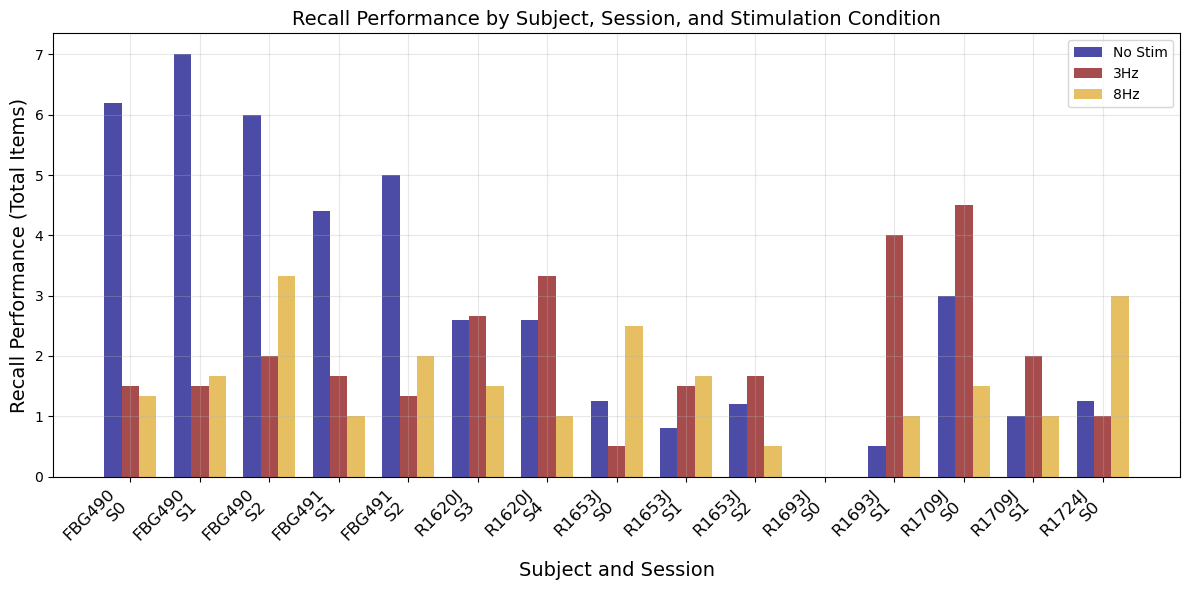

Summary Statistics:
Total subjects: 7
Total sessions: 15

Sessions with each condition:
No Stimulation: 15 sessions
3Hz Stimulation: 15 sessions
8Hz Stimulation: 15 sessions

Mean recall performance (only sessions where condition was present):
No Stimulation: 2.85 ± 2.31
3Hz Stimulation: 1.94 ± 1.23
8Hz Stimulation: 1.53 ± 0.89

Zero recall sessions (condition present but no items recalled):
No Stimulation: 1 sessions
3Hz Stimulation: 1 sessions
8Hz Stimulation: 1 sessions


In [14]:
# First, aggregate the trial-level data to subject/session level
# This assumes results_df is already created from your data processing code

# Aggregate data by subject and session
df_aggregated = results_df.groupby(['subject', 'session']).agg({
    'none_intrusion_count_no_stim': lambda x: np.nanmean(x) if x.notna().any() else np.nan,
    'none_intrusion_count_3hz': lambda x: np.nanmean(x) if x.notna().any() else np.nan,      
    'none_intrusion_count_8hz': lambda x: np.nanmean(x) if x.notna().any() else np.nan,
}).reset_index()

# Rename columns to match the original plot structure
df_aggregated = df_aggregated.rename(columns={
    'none_intrusion_count_no_stim': 'recall_no_stim',
    'none_intrusion_count_3hz': 'recall_3hz', 
    'none_intrusion_count_8hz': 'recall_8hz'
})

# Don't filter out NaN values - we need to handle them properly during plotting
df_filtered = df_aggregated.copy()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique subjects
subjects = df_filtered['subject'].unique()
x_positions = []
labels = []

# Plot data for each subject and session
x_pos = 0
for subject in subjects:
    subject_data = df_filtered[df_filtered['subject'] == subject]
    
    for _, row in subject_data.iterrows():
        # Handle values: NaN = condition not present (don't plot), 0 = no recalls (plot as 0)
        no_stim_val = row['recall_no_stim'] if pd.notna(row['recall_no_stim']) else None
        hz3_val = row['recall_3hz'] if pd.notna(row['recall_3hz']) else None
        hz8_val = row['recall_8hz'] if pd.notna(row['recall_8hz']) else None
        
        # Only plot bars for conditions that were actually present (not NaN)
        if no_stim_val is not None:
            ax.bar(x_pos - 0.25, no_stim_val, width=0.25, 
                   label='No Stim' if x_pos == 0 else "", color='Navy', alpha=0.7)
        
        if hz3_val is not None:
            ax.bar(x_pos, hz3_val, width=0.25, 
                   label='3Hz' if x_pos == 0 else "", color='maroon', alpha=0.7)
        
        if hz8_val is not None:
            ax.bar(x_pos + 0.25, hz8_val, width=0.25, 
                   label='8Hz' if x_pos == 0 else "", color='goldenrod', alpha=0.7)
        
        # Store position and label
        x_positions.append(x_pos)
        labels.append(f"{subject}\nS{int(row['session'])}")
        
        x_pos += 1

# Customize the plot
ax.set_xlabel('Subject and Session', fontsize=14)
ax.set_ylabel('Recall Performance (Total Items)', fontsize=14)
ax.set_title('Recall Performance by Subject, Session, and Stimulation Condition', fontsize=14)
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("recall_performance_by_stimulation.pdf", 
           transparent=True,      # Transparent background
           bbox_inches='tight',   # Removes extra whitespace
           pad_inches=0.08,       # Small padding around the figure
           format='pdf')    
plt.show()

# Print summary statistics (handling NaN vs 0 properly)
print("Summary Statistics:")
print(f"Total subjects: {df_filtered['subject'].nunique()}")
print(f"Total sessions: {len(df_filtered)}")

print("\nSessions with each condition:")
print(f"No Stimulation: {df_filtered['recall_no_stim'].notna().sum()} sessions")
print(f"3Hz Stimulation: {df_filtered['recall_3hz'].notna().sum()} sessions") 
print(f"8Hz Stimulation: {df_filtered['recall_8hz'].notna().sum()} sessions")

print("\nMean recall performance (only sessions where condition was present):")
if df_filtered['recall_no_stim'].notna().any():
    no_stim_mean = df_filtered['recall_no_stim'].mean()
    no_stim_std = df_filtered['recall_no_stim'].std()
    print(f"No Stimulation: {no_stim_mean:.2f} ± {no_stim_std:.2f}")

if df_filtered['recall_3hz'].notna().any():
    hz3_mean = df_filtered['recall_3hz'].mean()
    hz3_std = df_filtered['recall_3hz'].std()
    print(f"3Hz Stimulation: {hz3_mean:.2f} ± {hz3_std:.2f}")

if df_filtered['recall_8hz'].notna().any():
    hz8_mean = df_filtered['recall_8hz'].mean()
    hz8_std = df_filtered['recall_8hz'].std()
    print(f"8Hz Stimulation: {hz8_mean:.2f} ± {hz8_std:.2f}")

print("\nZero recall sessions (condition present but no items recalled):")
print(f"No Stimulation: {(df_filtered['recall_no_stim'] == 0).sum()} sessions")
print(f"3Hz Stimulation: {(df_filtered['recall_3hz'] == 0).sum()} sessions")
print(f"8Hz Stimulation: {(df_filtered['recall_8hz'] == 0).sum()} sessions")

In [13]:
df_aggregated

,subject,session,recall_no_stim,recall_3hz,recall_8hz
0,FBG490,0,6.20,1.500000,1.333333
1,FBG490,1,7.00,1.500000,1.666667
2,FBG490,2,6.00,2.000000,3.333333
3,FBG491,1,4.40,1.666667,1.000000
4,FBG491,2,5.00,1.333333,2.000000
5,R1620J,3,2.60,2.666667,1.500000
6,R1620J,4,2.60,3.333333,1.000000
7,R1653J,0,1.25,0.500000,2.500000
8,R1653J,1,0.80,1.500000,1.666667
9,R1653J,2,1.20,1.666667,0.500000



CHANGE vs NO STIMULATION BASELINE
INTRUSION CHANGES:
  3Hz vs No Stim: -0.18
  8Hz vs No Stim: -0.39

CORRECT RECALL CHANGES:
  3Hz vs No Stim: -1.14
  8Hz vs No Stim: -1.52

Plot saved as: efr_courier_simple_analysis.png
Results saved as: efr_courier_results.csv


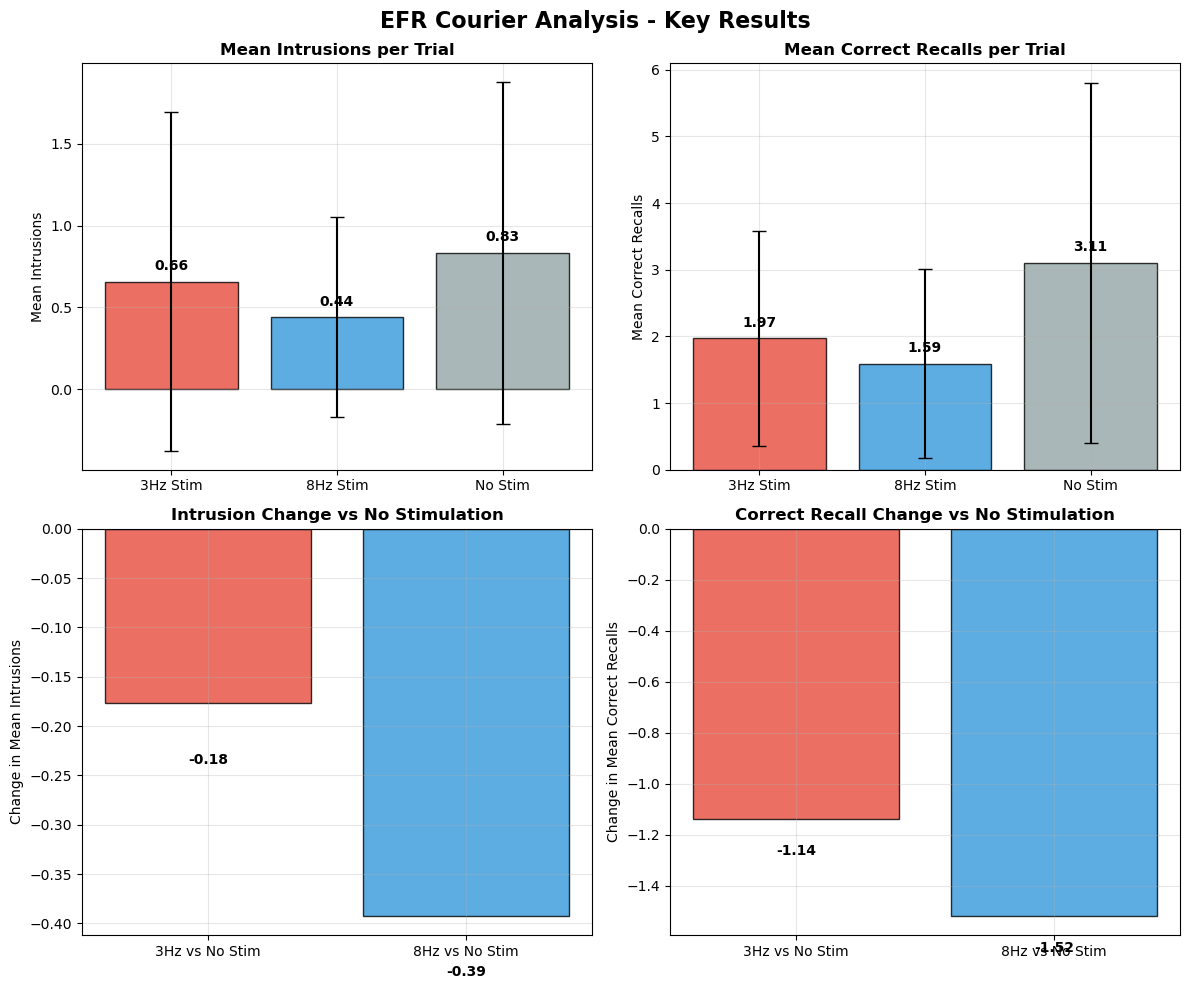


Analysis complete!


In [8]:
# Set up the figure
intrusion_3hz_mean = results_df['intrusion_count_3hz'].dropna().mean()
intrusion_3hz_std = results_df['intrusion_count_3hz'].dropna().std()
intrusion_8hz_mean = results_df['intrusion_count_8hz'].dropna().mean()
intrusion_8hz_std = results_df['intrusion_count_8hz'].dropna().std()
intrusion_no_stim_mean = results_df['intrusion_count_no_stim'].mean()
intrusion_no_stim_std = results_df['intrusion_count_no_stim'].std()

recall_3hz_mean = results_df['none_intrusion_count_3hz'].dropna().mean()
recall_3hz_std = results_df['none_intrusion_count_3hz'].dropna().std()
recall_8hz_mean = results_df['none_intrusion_count_8hz'].dropna().mean()
recall_8hz_std = results_df['none_intrusion_count_8hz'].dropna().std()
recall_no_stim_mean = results_df['none_intrusion_count_no_stim'].mean()
recall_no_stim_std = results_df['none_intrusion_count_no_stim'].std()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('EFR Courier Analysis - Key Results', fontsize=16, fontweight='bold')

# Colors for conditions
colors = ['#e74c3c', '#3498db', '#95a5a6']  # Red, Blue, Gray
condition_labels = ['3Hz Stim', '8Hz Stim', 'No Stim']

# Plot 1: Mean Intrusions per Trial
intrusion_means = [intrusion_3hz_mean, intrusion_8hz_mean, intrusion_no_stim_mean]
intrusion_stds = [intrusion_3hz_std, intrusion_8hz_std, intrusion_no_stim_std]

bars1 = ax1.bar(condition_labels, intrusion_means, yerr=intrusion_stds, 
                capsize=5, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Mean Intrusions per Trial', fontweight='bold')
ax1.set_ylabel('Mean Intrusions')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean in zip(bars1, intrusion_means):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(intrusion_stds)/20,
             f'{mean:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Mean Correct Recalls per Trial
recall_means = [recall_3hz_mean, recall_8hz_mean, recall_no_stim_mean]
recall_stds = [recall_3hz_std, recall_8hz_std, recall_no_stim_std]

bars2 = ax2.bar(condition_labels, recall_means, yerr=recall_stds,
                capsize=5, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_title('Mean Correct Recalls per Trial', fontweight='bold')
ax2.set_ylabel('Mean Correct Recalls')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean in zip(bars2, recall_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(recall_stds)/20,
             f'{mean:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Change in Intrusions vs No Stimulation Baseline
intrusion_change_3hz = intrusion_3hz_mean - intrusion_no_stim_mean
intrusion_change_8hz = intrusion_8hz_mean - intrusion_no_stim_mean
intrusion_changes = [intrusion_change_3hz, intrusion_change_8hz]
change_labels = ['3Hz vs No Stim', '8Hz vs No Stim']

bars3 = ax3.bar(change_labels, intrusion_changes, color=[colors[0], colors[1]], 
                alpha=0.8, edgecolor='black', linewidth=1)
ax3.set_title('Intrusion Change vs No Stimulation', fontweight='bold')
ax3.set_ylabel('Change in Mean Intrusions')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add value labels on bars
for bar, change in zip(bars3, intrusion_changes):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, 
             height + 0.05 if height >= 0 else height - 0.05,
             f'{change:.2f}', ha='center', 
             va='bottom' if height >= 0 else 'top', fontweight='bold')

# Plot 4: Change in Correct Recalls vs No Stimulation Baseline
recall_change_3hz = recall_3hz_mean - recall_no_stim_mean
recall_change_8hz = recall_8hz_mean - recall_no_stim_mean
recall_changes = [recall_change_3hz, recall_change_8hz]

bars4 = ax4.bar(change_labels, recall_changes, color=[colors[0], colors[1]], 
                alpha=0.8, edgecolor='black', linewidth=1)
ax4.set_title('Correct Recall Change vs No Stimulation', fontweight='bold')
ax4.set_ylabel('Change in Mean Correct Recalls')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add value labels on bars
for bar, change in zip(bars4, recall_changes):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2,
             height + 0.1 if height >= 0 else height - 0.1,
             f'{change:.2f}', ha='center',
             va='bottom' if height >= 0 else 'top', fontweight='bold')

# Adjust layout and show
plt.tight_layout()

# Print change statistics
print("\n" + "="*50)
print("CHANGE vs NO STIMULATION BASELINE")
print("="*50)
print("INTRUSION CHANGES:")
print(f"  3Hz vs No Stim: {intrusion_change_3hz:.2f}")
print(f"  8Hz vs No Stim: {intrusion_change_8hz:.2f}")
print()
print("CORRECT RECALL CHANGES:")
print(f"  3Hz vs No Stim: {recall_change_3hz:.2f}")
print(f"  8Hz vs No Stim: {recall_change_8hz:.2f}")

# Save the plot
plt.savefig('efr_courier_simple_analysis.png', dpi=300, bbox_inches='tight')
print(f"\nPlot saved as: efr_courier_simple_analysis.png")

# Save results to CSV
results_df.to_csv('efr_courier_results.csv', index=False)
print(f"Results saved as: efr_courier_results.csv")

plt.show()

print("\nAnalysis complete!")


SUBJECT-LEVEL ANALYSIS

INTRUSION MEANS BY SUBJECT:
Subject FBG490:
  3Hz: 0.00
  8Hz: 0.33
  No Stim: 1.40
Subject FBG491:
  3Hz: 0.83
  8Hz: 0.60
  No Stim: 2.00
Subject R1620J:
  3Hz: 1.00
  8Hz: 1.00
  No Stim: 0.20
Subject R1653J:
  3Hz: 0.14
  8Hz: 0.43
  No Stim: 0.29
Subject R1693J:
  3Hz: 2.00
  8Hz: 0.33
  No Stim: 0.67
Subject R1709J:
  3Hz: 0.33
  8Hz: 0.00
  No Stim: 0.29
Subject R1724J:
  3Hz: 2.00
  8Hz: 0.50
  No Stim: 0.50

OVERALL MEANS:
  3Hz: 0.66
  8Hz: 0.44
  No Stim: 0.83

CORRECT RECALL MEANS BY SUBJECT:
Subject FBG490:
  3Hz: 1.67
  8Hz: 2.11
  No Stim: 6.40
Subject FBG491:
  3Hz: 1.50
  8Hz: 1.40
  No Stim: 4.70
Subject R1620J:
  3Hz: 3.00
  8Hz: 1.25
  No Stim: 2.60
Subject R1653J:
  3Hz: 1.29
  8Hz: 1.57
  No Stim: 1.07
Subject R1693J:
  3Hz: 2.00
  8Hz: 0.33
  No Stim: 0.17
Subject R1709J:
  3Hz: 3.67
  8Hz: 1.25
  No Stim: 2.14
Subject R1724J:
  3Hz: 1.00
  8Hz: 3.00
  No Stim: 1.25

OVERALL MEANS:
  3Hz: 1.97
  8Hz: 1.59
  No Stim: 3.11

CHANGE SCORES BY

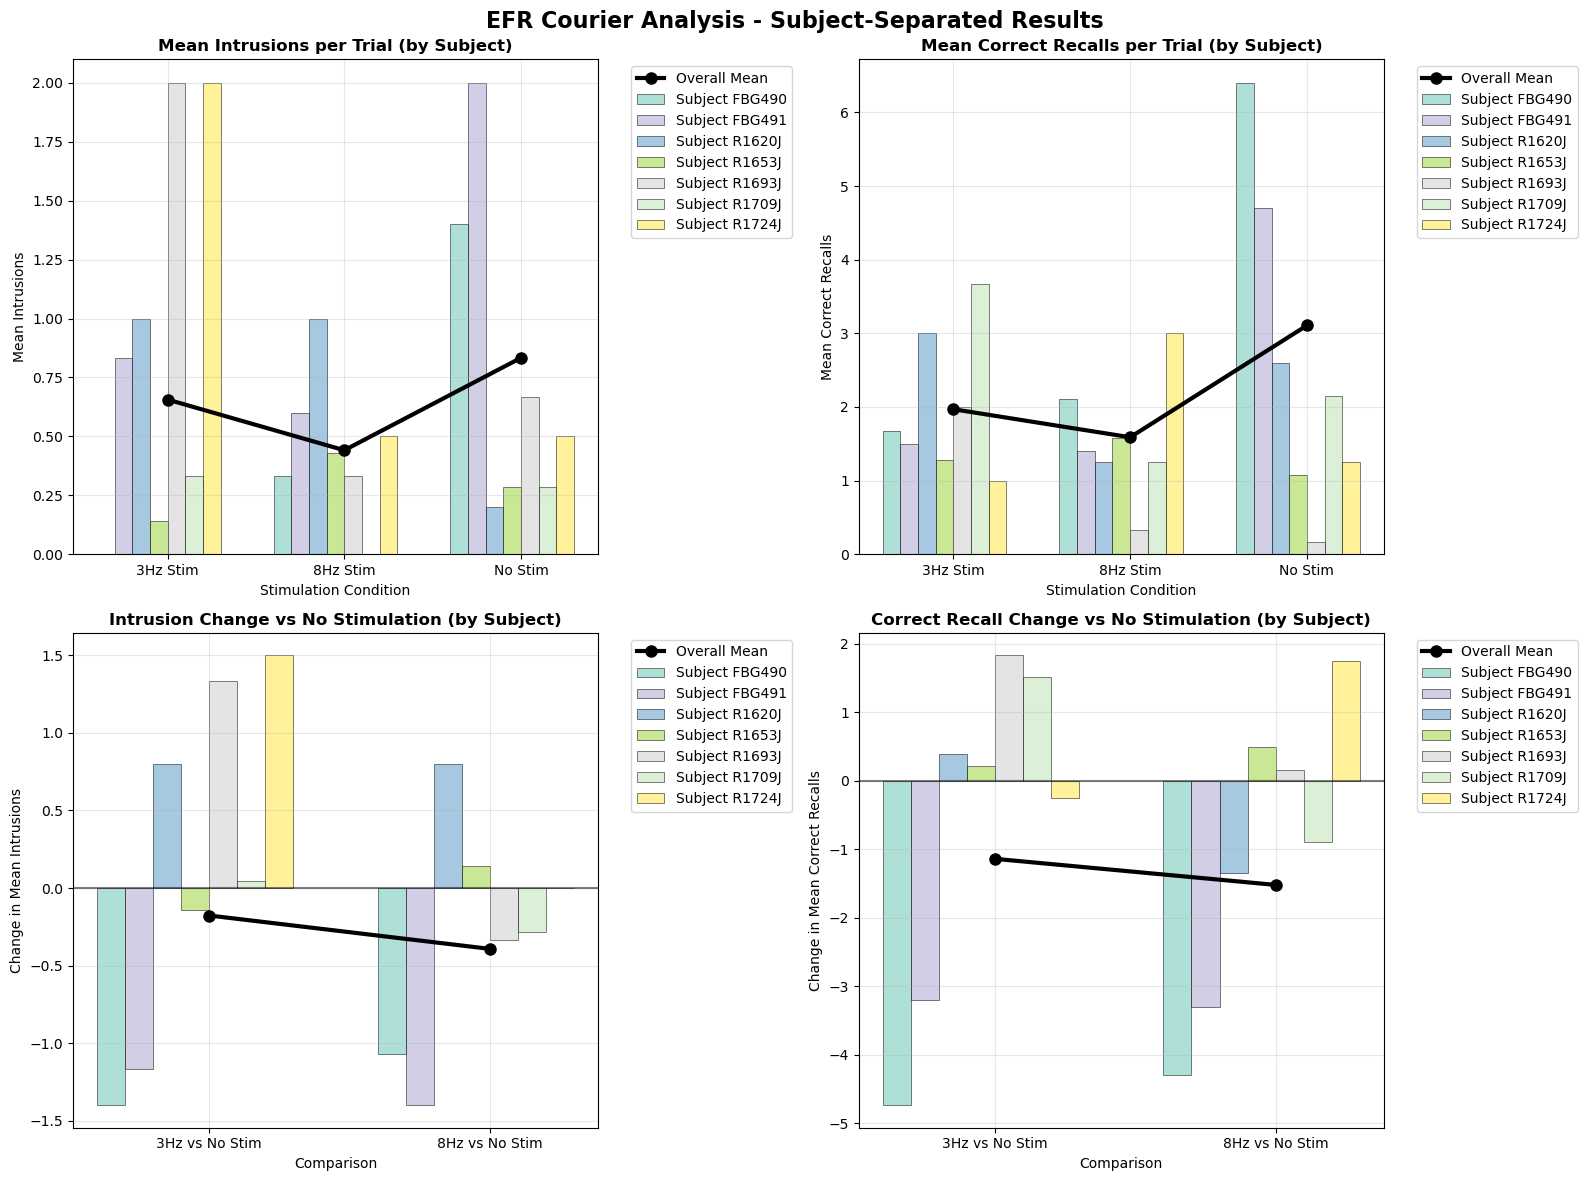


Subject-separated analysis complete!


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate subject-level means
subject_means = results_df.groupby('subject').agg({
    'intrusion_count_3hz': 'mean',
    'intrusion_count_8hz': 'mean', 
    'intrusion_count_no_stim': 'mean',
    'none_intrusion_count_3hz': 'mean',
    'none_intrusion_count_8hz': 'mean',
    'none_intrusion_count_no_stim': 'mean'
}).reset_index()

# Calculate overall means (for comparison)
overall_intrusion_3hz_mean = results_df['intrusion_count_3hz'].dropna().mean()
overall_intrusion_8hz_mean = results_df['intrusion_count_8hz'].dropna().mean()
overall_intrusion_no_stim_mean = results_df['intrusion_count_no_stim'].mean()

overall_recall_3hz_mean = results_df['none_intrusion_count_3hz'].dropna().mean()
overall_recall_8hz_mean = results_df['none_intrusion_count_8hz'].dropna().mean()
overall_recall_no_stim_mean = results_df['none_intrusion_count_no_stim'].mean()

# Calculate change scores for each subject
subject_means['intrusion_change_3hz'] = subject_means['intrusion_count_3hz'] - subject_means['intrusion_count_no_stim']
subject_means['intrusion_change_8hz'] = subject_means['intrusion_count_8hz'] - subject_means['intrusion_count_no_stim']
subject_means['recall_change_3hz'] = subject_means['none_intrusion_count_3hz'] - subject_means['none_intrusion_count_no_stim']
subject_means['recall_change_8hz'] = subject_means['none_intrusion_count_8hz'] - subject_means['none_intrusion_count_no_stim']

# Set up the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('EFR Courier Analysis - Subject-Separated Results', fontsize=16, fontweight='bold')

# Colors for conditions and subjects
colors = ['#e74c3c', '#3498db', '#95a5a6']  # Red, Blue, Gray
condition_labels = ['3Hz Stim', '8Hz Stim', 'No Stim']

# Get unique subjects for plotting
subjects = subject_means['subject'].unique()
n_subjects = len(subjects)

# Create color palette for subjects
subject_colors = plt.cm.Set3(np.linspace(0, 1, n_subjects))

# Plot 1: Mean Intrusions per Trial (by subject)
x_positions = np.arange(len(condition_labels))
width = 0.8 / (n_subjects + 1)  # Width for each subject bar

for i, subject in enumerate(subjects):
    subject_data = subject_means[subject_means['subject'] == subject]
    intrusion_means = [
        subject_data['intrusion_count_3hz'].iloc[0] if not pd.isna(subject_data['intrusion_count_3hz'].iloc[0]) else 0,
        subject_data['intrusion_count_8hz'].iloc[0] if not pd.isna(subject_data['intrusion_count_8hz'].iloc[0]) else 0,
        subject_data['intrusion_count_no_stim'].iloc[0]
    ]
    
    # Plot individual subject bars
    bars = ax1.bar(x_positions + (i - n_subjects/2) * width, intrusion_means, 
                   width, label=f'Subject {subject}', color=subject_colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)

# Add overall mean line
overall_intrusion_means = [overall_intrusion_3hz_mean, overall_intrusion_8hz_mean, overall_intrusion_no_stim_mean]
ax1.plot(x_positions, overall_intrusion_means, 'ko-', linewidth=3, markersize=8, label='Overall Mean')

ax1.set_title('Mean Intrusions per Trial (by Subject)', fontweight='bold')
ax1.set_ylabel('Mean Intrusions')
ax1.set_xlabel('Stimulation Condition')
ax1.set_xticks(x_positions)
ax1.set_xticklabels(condition_labels)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Mean Correct Recalls per Trial (by subject)
for i, subject in enumerate(subjects):
    subject_data = subject_means[subject_means['subject'] == subject]
    recall_means = [
        subject_data['none_intrusion_count_3hz'].iloc[0] if not pd.isna(subject_data['none_intrusion_count_3hz'].iloc[0]) else 0,
        subject_data['none_intrusion_count_8hz'].iloc[0] if not pd.isna(subject_data['none_intrusion_count_8hz'].iloc[0]) else 0,
        subject_data['none_intrusion_count_no_stim'].iloc[0]
    ]
    
    # Plot individual subject bars
    bars = ax2.bar(x_positions + (i - n_subjects/2) * width, recall_means, 
                   width, label=f'Subject {subject}', color=subject_colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)

# Add overall mean line
overall_recall_means = [overall_recall_3hz_mean, overall_recall_8hz_mean, overall_recall_no_stim_mean]
ax2.plot(x_positions, overall_recall_means, 'ko-', linewidth=3, markersize=8, label='Overall Mean')

ax2.set_title('Mean Correct Recalls per Trial (by Subject)', fontweight='bold')
ax2.set_ylabel('Mean Correct Recalls')
ax2.set_xlabel('Stimulation Condition')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(condition_labels)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 3: Change in Intrusions vs No Stimulation (by subject)
x_positions_change = np.arange(2)  # 3Hz vs No Stim, 8Hz vs No Stim
change_labels = ['3Hz vs No Stim', '8Hz vs No Stim']

for i, subject in enumerate(subjects):
    subject_data = subject_means[subject_means['subject'] == subject]
    intrusion_changes = [
        subject_data['intrusion_change_3hz'].iloc[0] if not pd.isna(subject_data['intrusion_change_3hz'].iloc[0]) else 0,
        subject_data['intrusion_change_8hz'].iloc[0] if not pd.isna(subject_data['intrusion_change_8hz'].iloc[0]) else 0
    ]
    
    # Plot individual subject bars
    bars = ax3.bar(x_positions_change + (i - n_subjects/2) * width, intrusion_changes, 
                   width, label=f'Subject {subject}', color=subject_colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)

# Add overall mean line
overall_intrusion_changes = [
    overall_intrusion_3hz_mean - overall_intrusion_no_stim_mean,
    overall_intrusion_8hz_mean - overall_intrusion_no_stim_mean
]
ax3.plot(x_positions_change, overall_intrusion_changes, 'ko-', linewidth=3, markersize=8, label='Overall Mean')

ax3.set_title('Intrusion Change vs No Stimulation (by Subject)', fontweight='bold')
ax3.set_ylabel('Change in Mean Intrusions')
ax3.set_xlabel('Comparison')
ax3.set_xticks(x_positions_change)
ax3.set_xticklabels(change_labels)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 4: Change in Correct Recalls vs No Stimulation (by subject)
for i, subject in enumerate(subjects):
    subject_data = subject_means[subject_means['subject'] == subject]
    recall_changes = [
        subject_data['recall_change_3hz'].iloc[0] if not pd.isna(subject_data['recall_change_3hz'].iloc[0]) else 0,
        subject_data['recall_change_8hz'].iloc[0] if not pd.isna(subject_data['recall_change_8hz'].iloc[0]) else 0
    ]
    
    # Plot individual subject bars
    bars = ax4.bar(x_positions_change + (i - n_subjects/2) * width, recall_changes, 
                   width, label=f'Subject {subject}', color=subject_colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)

# Add overall mean line
overall_recall_changes = [
    overall_recall_3hz_mean - overall_recall_no_stim_mean,
    overall_recall_8hz_mean - overall_recall_no_stim_mean
]
ax4.plot(x_positions_change, overall_recall_changes, 'ko-', linewidth=3, markersize=8, label='Overall Mean')

ax4.set_title('Correct Recall Change vs No Stimulation (by Subject)', fontweight='bold')
ax4.set_ylabel('Change in Mean Correct Recalls')
ax4.set_xlabel('Comparison')
ax4.set_xticks(x_positions_change)
ax4.set_xticklabels(change_labels)
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Print subject-level statistics
print("\n" + "="*60)
print("SUBJECT-LEVEL ANALYSIS")
print("="*60)

print("\nINTRUSION MEANS BY SUBJECT:")
for subject in subjects:
    subject_data = subject_means[subject_means['subject'] == subject]
    print(f"Subject {subject}:")
    print(f"  3Hz: {subject_data['intrusion_count_3hz'].iloc[0]:.2f}")
    print(f"  8Hz: {subject_data['intrusion_count_8hz'].iloc[0]:.2f}")
    print(f"  No Stim: {subject_data['intrusion_count_no_stim'].iloc[0]:.2f}")

print(f"\nOVERALL MEANS:")
print(f"  3Hz: {overall_intrusion_3hz_mean:.2f}")
print(f"  8Hz: {overall_intrusion_8hz_mean:.2f}")
print(f"  No Stim: {overall_intrusion_no_stim_mean:.2f}")

print("\nCORRECT RECALL MEANS BY SUBJECT:")
for subject in subjects:
    subject_data = subject_means[subject_means['subject'] == subject]
    print(f"Subject {subject}:")
    print(f"  3Hz: {subject_data['none_intrusion_count_3hz'].iloc[0]:.2f}")
    print(f"  8Hz: {subject_data['none_intrusion_count_8hz'].iloc[0]:.2f}")
    print(f"  No Stim: {subject_data['none_intrusion_count_no_stim'].iloc[0]:.2f}")

print(f"\nOVERALL MEANS:")
print(f"  3Hz: {overall_recall_3hz_mean:.2f}")
print(f"  8Hz: {overall_recall_8hz_mean:.2f}")
print(f"  No Stim: {overall_recall_no_stim_mean:.2f}")

print("\nCHANGE SCORES BY SUBJECT:")
for subject in subjects:
    subject_data = subject_means[subject_means['subject'] == subject]
    print(f"Subject {subject}:")
    print(f"  Intrusion Change - 3Hz vs No Stim: {subject_data['intrusion_change_3hz'].iloc[0]:.2f}")
    print(f"  Intrusion Change - 8Hz vs No Stim: {subject_data['intrusion_change_8hz'].iloc[0]:.2f}")
    print(f"  Recall Change - 3Hz vs No Stim: {subject_data['recall_change_3hz'].iloc[0]:.2f}")
    print(f"  Recall Change - 8Hz vs No Stim: {subject_data['recall_change_8hz'].iloc[0]:.2f}")

# Save the plot
plt.savefig('efr_courier_subject_separated_analysis.png', dpi=300, bbox_inches='tight')
print(f"\nPlot saved as: efr_courier_subject_separated_analysis.png")

# Save subject-level results to CSV
subject_means.to_csv('efr_courier_subject_means.csv', index=False)
print(f"Subject-level results saved as: efr_courier_subject_means.csv")

plt.show()

print("\nSubject-separated analysis complete!")

In [75]:
Index=evs[evs['type']=="WORD"].index
evs.iloc[Index-1]['type']
MASK=evs.iloc[Index-1]['type']=='STIM'
NewINDEX=evs.iloc[Index-1][MASK].index

evs.iloc[NewINDEX+1]['stim_params']
for row_idx in NewINDEX:
               evs.loc[row_idx+1, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
            

In [77]:
evs.iloc[NewINDEX+1]

,eegoffset,correctPointingDirection,eegfile,efr_mark,experiment,finalrecalled,intruded,intrusion,item,itemno,...,session,stim_params,store,storeX,storeZ,subject,submittedPointingDirection,trial,type,inside_stimuli
61,1038842,-999.0,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,ROLL,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",bakery,14.546875,-58.781250,R1724J,-999.0,0,WORD,8
71,1122939,-999.0,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,VITAMINS,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",pharmacy,35.406250,-33.125000,R1724J,-999.0,0,WORD,8
79,1187663,-999.0,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,EMERALD,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",jewelry_store,-14.250000,-12.890625,R1724J,-999.0,0,WORD,8
86,1232055,-999.0,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,FLUORIDE,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",dentist,32.187500,-60.906250,R1724J,-999.0,0,WORD,8
93,1278581,-999.0,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,PURSE,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",clothing_store,59.281250,-9.156250,R1724J,-999.0,0,WORD,8
97,1305930,-999.0,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,OREGANO,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",pizzeria,-29.562500,-37.250000,R1724J,-999.0,0,WORD,8
149,1626283,-999.0,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,ANCHOVIES,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",pizzeria,-29.562500,-37.250000,R1724J,-999.0,1,WORD,8
156,1694299,-999.0,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,ASPIRIN,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",pharmacy,35.406250,-33.125000,R1724J,-999.0,1,WORD,8
165,1789008,-999.0,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,SYRINGE,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",dentist,32.187500,-60.906250,R1724J,-999.0,1,WORD,8
173,1852074,-999.0,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,SANDALS,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",clothing_store,59.281250,-9.156250,R1724J,-999.0,1,WORD,8


In [33]:
evs.head(100)

,eegoffset,correctPointingDirection,eegfile,efr_mark,experiment,finalrecalled,intruded,intrusion,item,itemno,...,session,stim_params,store,storeX,storeZ,subject,submittedPointingDirection,trial,type,inside_stimuli
0,8741,-999.0000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,-999.00000,-999.00000,R1724J,-999.00,-999,START,-999
1,8808,-999.0000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,-999.00000,-999.00000,R1724J,-999.00,-999,store mappings,-999
2,136651,-999.0000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,-999.00000,-999.00000,R1724J,-999.00,-999,TL_START,-999
3,136651,-999.0000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",pizzeria,-999.00000,-999.00000,R1724J,-999.00,-999,pointing begins,-999
4,142352,213.6250,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,-999.00000,-999.00000,R1724J,296.25,-999,pointing finished,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1286050,253.1250,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",-999,59.28125,-9.15625,R1724J,302.50,0,pointing finished,-999
96,1305335,-999.0000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 0, 'amplitude': 0.7001953125, 'ano...",-999,-999.00000,-999.00000,R1724J,-999.00,0,STIM,-999
97,1305930,-999.0000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,0,0,-999,OREGANO,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",pizzeria,-29.56250,-37.25000,R1724J,-999.00,0,WORD,3
98,1308187,-999.0000,R1724J_EFRCourierOpenLoop_0_28Jan24_1650,-999,EFRCourierOpenLoop,-999,-999,-999,-999,-999,...,0,"{'_remove': 1, 'amplitude': -1.0, 'anode_label...",barber shop,-29.56250,-37.25000,R1724J,-999.00,0,pointing begins,3


In [79]:
trial_evs = evs[evs['trial'] == trial]
                    
# Filter for intrusions with additional conditions for this trial
intrusion_events = trial_evs[((trial_evs['intrusion'] > 0) | (trial_evs['intrusion'] == -1)) & 
                            (trial_evs['type'] == 'REC_WORD') & 
                            (trial_evs['phase'] == 'retrieval')]
none_intrusion_events = trial_evs[(trial_evs['intrusion'] == 0) & 
                                 (trial_evs['type'] == 'REC_WORD') & 
                                 (trial_evs['phase'] == 'retrieval')]

In [115]:
DuringSTIM_no=none_intrusion_events['inside_stimuli']==-999
No_stimuli_item=none_intrusion_events[DuringSTIM_no]['item']
DuringSTIM_yes=(none_intrusion_events['inside_stimuli']==3)|(none_intrusion_events['inside_stimuli']==8)
With_stimuli_item=none_intrusion_events[DuringSTIM_yes]['item']
Encode_withStimulation_item=trial_evs[(trial_evs['type']=='WORD') & ( (trial_evs['inside_stimuli']==3)| (trial_evs['inside_stimuli']==8))]['item']
Encode_without_Stimulation_item=trial_evs[(trial_evs['type']=='WORD') & (trial_evs['inside_stimuli']==-999)]['item']
# Convert to sets for efficient intersection operations
with_stimuli_set = set(With_stimuli_item)
encode_with_stim_set = set(Encode_withStimulation_item)
encode_without_stim_set = set(Encode_without_Stimulation_item)
no_stimuli_set = set(No_stimuli_item)

# Calculate overlaps for With_stimuli_item
with_stim_from_encode_with = len(with_stimuli_set.intersection(encode_with_stim_set))
with_stim_from_encode_without = len(with_stimuli_set.intersection(encode_without_stim_set))

# Calculate overlaps for No_stimuli_item  
no_stim_from_encode_with = len(no_stimuli_set.intersection(encode_with_stim_set))
no_stim_from_encode_without = len(no_stimuli_set.intersection(encode_without_stim_set))

In [116]:
# Print results
print("With_stimuli_item analysis:")
print(f"  Items from Encode_withStimulation: {with_stim_from_encode_with}")
print(f"  Items from Encode_without_Stimulation: {with_stim_from_encode_without}")
print(f"  Total With_stimuli_items: {len(with_stimuli_set)}")

print("\nNo_stimuli_item analysis:")
print(f"  Items from Encode_withStimulation: {no_stim_from_encode_with}")
print(f"  Items from Encode_without_Stimulation: {no_stim_from_encode_without}")
print(f"  Total No_stimuli_items: {len(no_stimuli_set)}")

With_stimuli_item analysis:
  Items from Encode_withStimulation: 1
  Items from Encode_without_Stimulation: 3
  Total With_stimuli_items: 4

No_stimuli_item analysis:
  Items from Encode_withStimulation: 1
  Items from Encode_without_Stimulation: 2
  Total No_stimuli_items: 3



STATE-DEPENDENT MEMORY ANALYSIS

3Hz STIMULATION RESULTS:
----------------------------------------
Condition				Overall Mean ± SD
Encode: STIM, Retrieve: STIM  	0.93 ± 0.58
Encode: NO, Retrieve: STIM    	0.94 ± 0.48
Encode: STIM, Retrieve: NO    	1.15 ± 1.17
Encode: NO, Retrieve: NO      	1.34 ± 1.40

8Hz STIMULATION RESULTS:
----------------------------------------
Encode: STIM, Retrieve: STIM  	0.50 ± 0.19
Encode: NO, Retrieve: STIM    	1.08 ± 0.62
Encode: STIM, Retrieve: NO    	1.16 ± 0.84
Encode: NO, Retrieve: NO      	1.23 ± 1.10

SUBJECT-LEVEL BREAKDOWN:
----------------------------------------

Subject FBG490:
  3Hz Conditions:
    Encode: STIM, Retrieve: STIM: 0.83
    Encode: NO, Retrieve: STIM: 0.83
    Encode: STIM, Retrieve: NO: 3.00
    Encode: NO, Retrieve: NO : 4.00
  8Hz Conditions:
    Encode: STIM, Retrieve: STIM: 0.67
    Encode: NO, Retrieve: STIM: 1.44
    Encode: STIM, Retrieve: NO: 2.11
    Encode: NO, Retrieve: NO : 3.44

Subject FBG491:
  3Hz Conditions:
    E

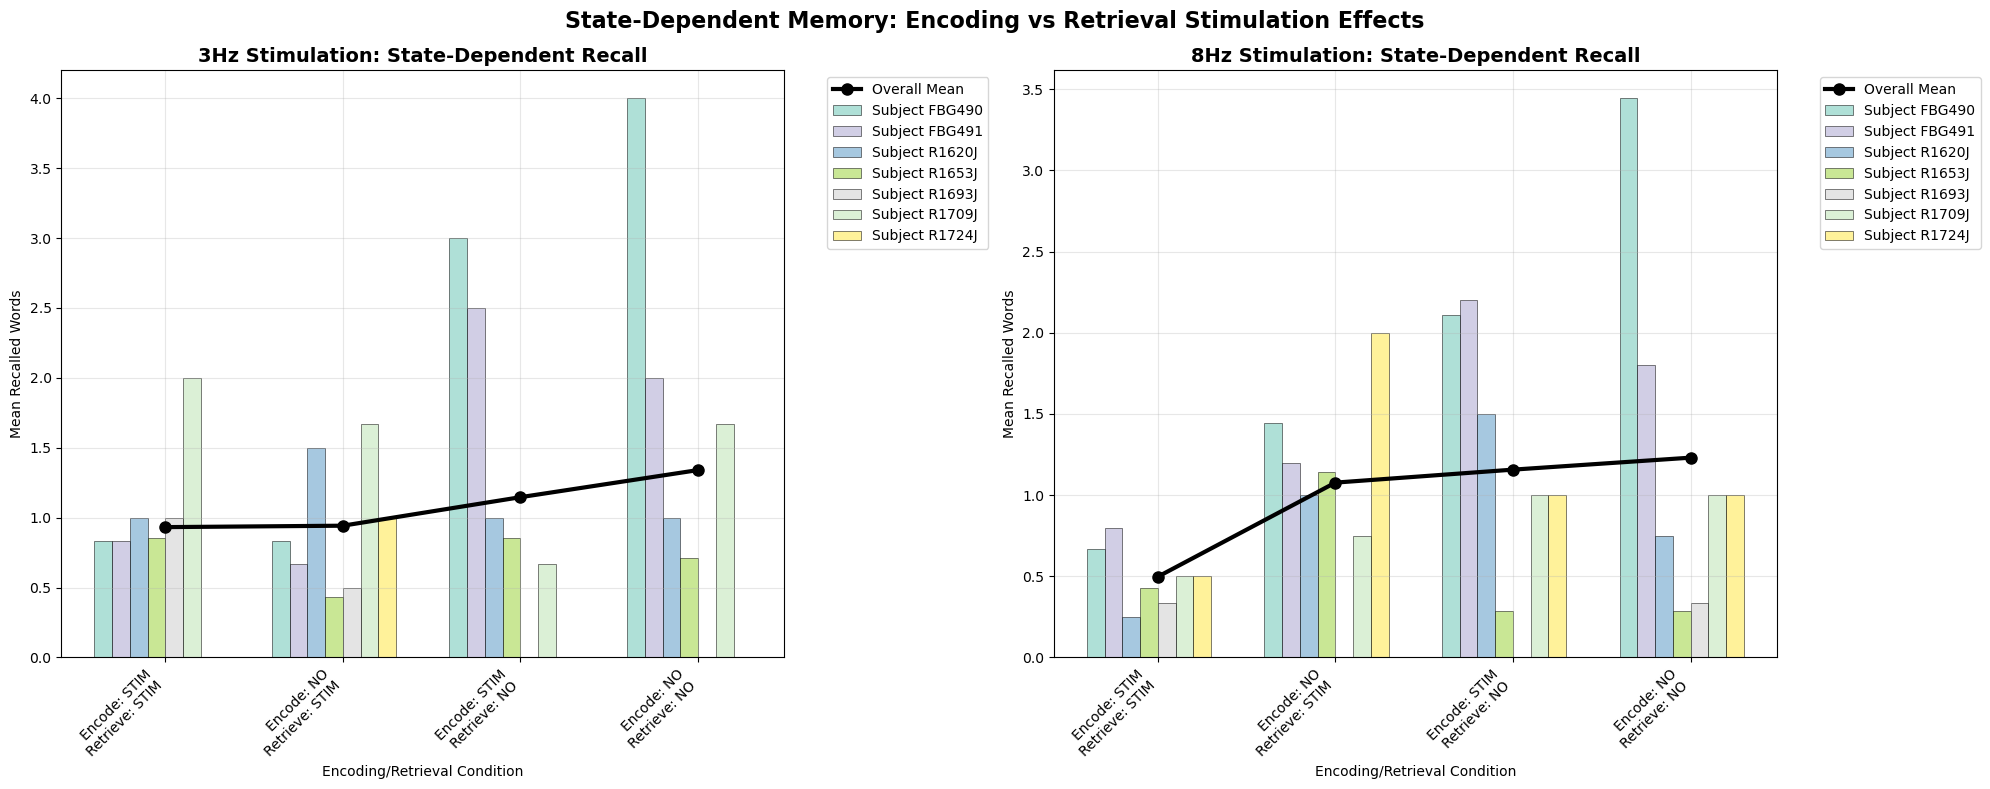

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is already available from the previous analysis
# Create subject-level means for state-dependent encoding/retrieval analysis

def calculate_state_dependent_means(results_df):
    """Calculate subject-level means for state-dependent memory analysis"""
    
    # Define the columns for each stimulation frequency and encoding/retrieval combination
    state_columns_3hz = [
        'encode_STIM_retrival_STIM_3hz',  # Encoded WITH stim, Retrieved WITH 3Hz stim
        'encode_No_retrival_STIM_3hz',    # Encoded WITHOUT stim, Retrieved WITH 3Hz stim  
        'encode_STIM_retrival_No_3hz',    # Encoded WITH stim, Retrieved WITHOUT stim (when 3Hz present)
        'encode_No_retrival_No_3hz'       # Encoded WITHOUT stim, Retrieved WITHOUT stim (when 3Hz present)
    ]
    
    state_columns_8hz = [
        'encode_STIM_retrival_STIM_8hz',  # Encoded WITH stim, Retrieved WITH 8Hz stim
        'encode_No_retrival_STIM_8hz',    # Encoded WITHOUT stim, Retrieved WITH 8Hz stim
        'encode_STIM_retrival_No_8hz',    # Encoded WITH stim, Retrieved WITHOUT stim (when 8Hz present)  
        'encode_No_retrival_No_8hz'       # Encoded WITHOUT stim, Retrieved WITHOUT stim (when 8Hz present)
    ]
    
    # Calculate subject-level means, handling NaN values
    subject_state_means = results_df.groupby('subject').agg({
        **{col: 'mean' for col in state_columns_3hz},
        **{col: 'mean' for col in state_columns_8hz}
    }).reset_index()
    
    return subject_state_means

def plot_state_dependent_analysis(subject_state_means):
    """Create state-dependent memory visualization - absolute values only"""
    
    # Set up the figure with subplots for 3Hz and 8Hz conditions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('State-Dependent Memory: Encoding vs Retrieval Stimulation Effects', 
                 fontsize=16, fontweight='bold')
    
    subjects = subject_state_means['subject'].unique()
    n_subjects = len(subjects)
    
    # Create color palette for subjects
    subject_colors = plt.cm.Set3(np.linspace(0, 1, n_subjects))
    
    # Define the 2x2 matrix positions for encoding/retrieval combinations
    conditions_3hz = ['encode_STIM_retrival_STIM_3hz', 'encode_No_retrival_STIM_3hz', 
                      'encode_STIM_retrival_No_3hz', 'encode_No_retrival_No_3hz']
    conditions_8hz = ['encode_STIM_retrival_STIM_8hz', 'encode_No_retrival_STIM_8hz',
                      'encode_STIM_retrival_No_8hz', 'encode_No_retrival_No_8hz']
    
    condition_labels = ['Encode: STIM\nRetrieve: STIM', 'Encode: NO\nRetrieve: STIM',
                       'Encode: STIM\nRetrieve: NO', 'Encode: NO\nRetrieve: NO']
    
    # Plot 1: 3Hz Condition - Absolute Values
    x_positions = np.arange(len(conditions_3hz))
    width = 0.8 / (n_subjects + 1)
    
    for i, subject in enumerate(subjects):
        subject_data = subject_state_means[subject_state_means['subject'] == subject]
        values_3hz = [subject_data[col].iloc[0] if not pd.isna(subject_data[col].iloc[0]) else 0 
                      for col in conditions_3hz]
        
        bars = ax1.bar(x_positions + (i - n_subjects/2) * width, values_3hz,
                      width, label=f'Subject {subject}', color=subject_colors[i], 
                      alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Add overall mean line for 3Hz
    overall_means_3hz = [subject_state_means[col].mean() for col in conditions_3hz]
    ax1.plot(x_positions, overall_means_3hz, 'ko-', linewidth=3, markersize=8, label='Overall Mean')
    
    ax1.set_title('3Hz Stimulation: State-Dependent Recall', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Mean Recalled Words')
    ax1.set_xlabel('Encoding/Retrieval Condition')
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(condition_labels, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 2: 8Hz Condition - Absolute Values  
    for i, subject in enumerate(subjects):
        subject_data = subject_state_means[subject_state_means['subject'] == subject]
        values_8hz = [subject_data[col].iloc[0] if not pd.isna(subject_data[col].iloc[0]) else 0 
                      for col in conditions_8hz]
        
        bars = ax2.bar(x_positions + (i - n_subjects/2) * width, values_8hz,
                      width, label=f'Subject {subject}', color=subject_colors[i], 
                      alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Add overall mean line for 8Hz
    overall_means_8hz = [subject_state_means[col].mean() for col in conditions_8hz]
    ax2.plot(x_positions, overall_means_8hz, 'ko-', linewidth=3, markersize=8, label='Overall Mean')
    
    ax2.set_title('8Hz Stimulation: State-Dependent Recall', fontweight='bold', fontsize=14)
    ax2.set_ylabel('Mean Recalled Words')
    ax2.set_xlabel('Encoding/Retrieval Condition')
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels(condition_labels, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    return fig, (overall_means_3hz, overall_means_8hz)

def print_state_dependent_statistics(subject_state_means):
    """Print detailed statistics for state-dependent analysis"""
    
    print("\n" + "="*80)
    print("STATE-DEPENDENT MEMORY ANALYSIS")
    print("="*80)
    
    subjects = subject_state_means['subject'].unique()
    
    print("\n3Hz STIMULATION RESULTS:")
    print("-" * 40)
    print("Condition\t\t\t\tOverall Mean ± SD")
    
    conditions_3hz = {
        'encode_STIM_retrival_STIM_3hz': 'Encode: STIM, Retrieve: STIM',
        'encode_No_retrival_STIM_3hz': 'Encode: NO, Retrieve: STIM',
        'encode_STIM_retrival_No_3hz': 'Encode: STIM, Retrieve: NO', 
        'encode_No_retrival_No_3hz': 'Encode: NO, Retrieve: NO'
    }
    
    for col, label in conditions_3hz.items():
        mean_val = subject_state_means[col].mean()
        std_val = subject_state_means[col].std()
        print(f"{label:30s}\t{mean_val:.2f} ± {std_val:.2f}")
    
    print("\n8Hz STIMULATION RESULTS:")
    print("-" * 40)
    
    conditions_8hz = {
        'encode_STIM_retrival_STIM_8hz': 'Encode: STIM, Retrieve: STIM',
        'encode_No_retrival_STIM_8hz': 'Encode: NO, Retrieve: STIM',
        'encode_STIM_retrival_No_8hz': 'Encode: STIM, Retrieve: NO',
        'encode_No_retrival_No_8hz': 'Encode: NO, Retrieve: NO'
    }
    
    for col, label in conditions_8hz.items():
        mean_val = subject_state_means[col].mean()
        std_val = subject_state_means[col].std()
        print(f"{label:30s}\t{mean_val:.2f} ± {std_val:.2f}")
    
    print("\nSUBJECT-LEVEL BREAKDOWN:")
    print("-" * 40)
    
    for subject in subjects:
        subject_data = subject_state_means[subject_state_means['subject'] == subject]
        print(f"\nSubject {subject}:")
        print("  3Hz Conditions:")
        for col, label in conditions_3hz.items():
            val = subject_data[col].iloc[0]
            print(f"    {label:25s}: {val:.2f}" if not pd.isna(val) else f"    {label:25s}: N/A")
        
        print("  8Hz Conditions:")
        for col, label in conditions_8hz.items():
            val = subject_data[col].iloc[0]
            print(f"    {label:25s}: {val:.2f}" if not pd.isna(val) else f"    {label:25s}: N/A")

# Main execution
if __name__ == "__main__":
    # Note: This assumes 'results_df' is available from the previous analysis
    # If running standalone, you would need to load the data first
    
    # Calculate state-dependent means
    subject_state_means = calculate_state_dependent_means(results_df)
    
    # Create the visualization
    fig, statistics = plot_state_dependent_analysis(subject_state_means)
    
    # Print detailed statistics
    print_state_dependent_statistics(subject_state_means)
    
    # Save the results
    plt.savefig('state_dependent_memory_analysis.png', dpi=300, bbox_inches='tight')
    subject_state_means.to_csv('subject_state_dependent_means.csv', index=False)
    
    print(f"\nState-dependent analysis complete!")
    print(f"Visualization saved as: state_dependent_memory_analysis.png")
    print(f"Data saved as: subject_state_dependent_means.csv")
    
    plt.show()

In [147]:
import pandas as pd
import numpy as np

def reorganize_state_dependent_data(results_df):
    """
    Reorganize the data to have each subject-session-trial as a row with 
    encoding/retrieval states as separate columns and frequency indicator.
    
    Parameters:
    results_df: DataFrame from the original analysis with state-dependent columns
    
    Returns:
    reorganized_df: DataFrame in long format with unified column names
    """
    
    # Create empty list to store reorganized data
    reorganized_data = []
    
    # Process each row in the original results_df
    for _, row in results_df.iterrows():
        subject = row['subject']
        session = row['session'] 
        trial = row['trial']
        
        # Check if this trial has 3Hz data
        if not pd.isna(row['encode_STIM_retrival_STIM_3hz']):
            # Create 3Hz row
            hz_3_row = {
                'subject': subject,
                'session': session,
                'trial': trial,
                'frequency': '3Hz',
                'encode_STIM_retrival_STIM': row['encode_STIM_retrival_STIM_3hz'],
                'encode_No_retrival_STIM': row['encode_No_retrival_STIM_3hz'],
                'encode_STIM_retrival_No': row['encode_STIM_retrival_No_3hz'],
                'encode_No_retrival_No': row['encode_No_retrival_No_3hz'],
                # Include other relevant trial information
                'intrusion_count_stim': row['intrusion_count_3hz'],
                'intrusion_count_no_stim': row['intrusion_count_no_stim'],
                'none_intrusion_count_stim': row['none_intrusion_count_3hz'],
                'none_intrusion_count_no_stim': row['none_intrusion_count_no_stim'],
                'intrusion_count_total': row['intrusion_count_total'],
                'none_intrusion_count_total': row['none_intrusion_count_total']
            }
            reorganized_data.append(hz_3_row)
        
        # Check if this trial has 8Hz data
        if not pd.isna(row['encode_STIM_retrival_STIM_8hz']):
            # Create 8Hz row
            hz_8_row = {
                'subject': subject,
                'session': session,
                'trial': trial,
                'frequency': '8Hz',
                'encode_STIM_retrival_STIM': row['encode_STIM_retrival_STIM_8hz'],
                'encode_No_retrival_STIM': row['encode_No_retrival_STIM_8hz'],
                'encode_STIM_retrival_No': row['encode_STIM_retrival_No_8hz'],
                'encode_No_retrival_No': row['encode_No_retrival_No_8hz'],
                # Include other relevant trial information
                'intrusion_count_stim': row['intrusion_count_8hz'],
                'intrusion_count_no_stim': row['intrusion_count_no_stim'],
                'none_intrusion_count_stim': row['none_intrusion_count_8hz'],
                'none_intrusion_count_no_stim': row['none_intrusion_count_no_stim'],
                'intrusion_count_total': row['intrusion_count_total'],
                'none_intrusion_count_total': row['none_intrusion_count_total']
            }
            reorganized_data.append(hz_8_row)
    
    # Convert to DataFrame
    reorganized_df = pd.DataFrame(reorganized_data)
    
    return reorganized_df

def add_derived_metrics(reorganized_df):
    """
    Add derived metrics to the reorganized DataFrame for easier analysis.
    
    Parameters:
    reorganized_df: DataFrame from reorganize_state_dependent_data()
    
    Returns:
    enhanced_df: DataFrame with additional calculated columns
    """
    
    enhanced_df = reorganized_df.copy()
    
    # Calculate total recalled words for each encoding/retrieval state
    enhanced_df['total_recalled_words'] = (
        enhanced_df['encode_STIM_retrival_STIM'] + 
        enhanced_df['encode_No_retrival_STIM'] + 
        enhanced_df['encode_STIM_retrival_No'] + 
        enhanced_df['encode_No_retrival_No']
    )
    
    # Calculate state-dependent effects (matching vs. mismatching contexts)
    # Matching: both encoding and retrieval have same stimulation state
    enhanced_df['matching_contexts'] = (
        enhanced_df['encode_STIM_retrival_STIM'] + 
        enhanced_df['encode_No_retrival_No']
    )
    
    # Mismatching: encoding and retrieval have different stimulation states  
    enhanced_df['mismatching_contexts'] = (
        enhanced_df['encode_No_retrival_STIM'] + 
        enhanced_df['encode_STIM_retrival_No']
    )
    
    # State-dependency advantage (matching - mismatching)
    enhanced_df['state_dependency_advantage'] = (
        enhanced_df['matching_contexts'] - enhanced_df['mismatching_contexts']
    )
    
    # Encoding effect (comparing words encoded with vs without stimulation)
    enhanced_df['encoding_with_stim'] = (
        enhanced_df['encode_STIM_retrival_STIM'] + 
        enhanced_df['encode_STIM_retrival_No']
    )
    
    enhanced_df['encoding_without_stim'] = (
        enhanced_df['encode_No_retrival_STIM'] + 
        enhanced_df['encode_No_retrival_No']
    )
    
    enhanced_df['encoding_stim_effect'] = (
        enhanced_df['encoding_with_stim'] - enhanced_df['encoding_without_stim']
    )
    
    # Retrieval effect (comparing words retrieved with vs without stimulation)
    enhanced_df['retrieval_with_stim'] = (
        enhanced_df['encode_STIM_retrival_STIM'] + 
        enhanced_df['encode_No_retrival_STIM']
    )
    
    enhanced_df['retrieval_without_stim'] = (
        enhanced_df['encode_STIM_retrival_No'] + 
        enhanced_df['encode_No_retrival_No']
    )
    
    enhanced_df['retrieval_stim_effect'] = (
        enhanced_df['retrieval_with_stim'] - enhanced_df['retrieval_without_stim']
    )
    
    return enhanced_df

def summarize_reorganized_data(enhanced_df):
    """
    Print summary statistics for the reorganized data.
    
    Parameters:
    enhanced_df: DataFrame from add_derived_metrics()
    """
    
    print("=" * 80)
    print("REORGANIZED DATA SUMMARY")
    print("=" * 80)
    
    print(f"\nDataFrame Shape: {enhanced_df.shape}")
    print(f"Unique Subjects: {enhanced_df['subject'].nunique()}")
    print(f"Unique Sessions: {enhanced_df['session'].nunique()}")
    print(f"Unique Trials: {enhanced_df['trial'].nunique()}")
    print(f"Frequency Distribution:")
    print(enhanced_df['frequency'].value_counts())
    
    print("\nColumn Information:")
    print("-" * 50)
    column_descriptions = {
        'subject': 'Subject identifier',
        'session': 'Session number',
        'trial': 'Trial number',
        'frequency': 'Stimulation frequency (3Hz or 8Hz)',
        'encode_STIM_retrival_STIM': 'Words encoded WITH stim, retrieved WITH stim',
        'encode_No_retrival_STIM': 'Words encoded WITHOUT stim, retrieved WITH stim',
        'encode_STIM_retrival_No': 'Words encoded WITH stim, retrieved WITHOUT stim',
        'encode_No_retrival_No': 'Words encoded WITHOUT stim, retrieved WITHOUT stim',
        'total_recalled_words': 'Sum of all recalled words in trial',
        'matching_contexts': 'Words with matching encoding/retrieval contexts',
        'mismatching_contexts': 'Words with mismatching encoding/retrieval contexts',
        'state_dependency_advantage': 'Matching contexts - Mismatching contexts',
        'encoding_stim_effect': 'Effect of stimulation during encoding',
        'retrieval_stim_effect': 'Effect of stimulation during retrieval'
    }
    
    for col, desc in column_descriptions.items():
        if col in enhanced_df.columns:
            print(f"{col:30s}: {desc}")
    
    print("\nSample Data (first 5 rows):")
    print("-" * 50)
    display_columns = ['subject', 'session', 'trial', 'frequency', 
                      'encode_STIM_retrival_STIM', 'encode_No_retrival_STIM',
                      'encode_STIM_retrival_No', 'encode_No_retrival_No']
    print(enhanced_df[display_columns].head())
    
    print("\nDescriptive Statistics for State-Dependent Measures:")
    print("-" * 60)
    analysis_columns = ['encode_STIM_retrival_STIM', 'encode_No_retrival_STIM',
                       'encode_STIM_retrival_No', 'encode_No_retrival_No',
                       'state_dependency_advantage', 'encoding_stim_effect', 
                       'retrieval_stim_effect']
    
    for col in analysis_columns:
        if col in enhanced_df.columns:
            mean_val = enhanced_df[col].mean()
            std_val = enhanced_df[col].std()
            print(f"{col:30s}: {mean_val:6.2f} ± {std_val:5.2f}")
    
    print("\nFrequency-Specific Statistics:")
    print("-" * 40)
    for freq in ['3Hz', '8Hz']:
        freq_data = enhanced_df[enhanced_df['frequency'] == freq]
        if len(freq_data) > 0:
            print(f"\n{freq} Stimulation (n={len(freq_data)} trials):")
            for col in ['encode_STIM_retrival_STIM', 'encode_No_retrival_STIM',
                       'encode_STIM_retrival_No', 'encode_No_retrival_No']:
                mean_val = freq_data[col].mean()
                std_val = freq_data[col].std()
                print(f"  {col:25s}: {mean_val:6.2f} ± {std_val:5.2f}")

# Main execution function
def main(results_df):
    """
    Main function to reorganize and analyze the state-dependent data.
    
    Parameters:
    results_df: Original DataFrame from the EFR Courier analysis
    
    Returns:
    enhanced_df: Reorganized DataFrame ready for analysis
    """
    
    print("Starting data reorganization...")
    
    # Step 1: Reorganize the data
    reorganized_df = reorganize_state_dependent_data(results_df)
    print(f"Data reorganized: {len(reorganized_df)} rows created")
    
    # Step 2: Add derived metrics
    enhanced_df = add_derived_metrics(reorganized_df)
    print("Derived metrics calculated")
    
    # Step 3: Print summary
    summarize_reorganized_data(enhanced_df)
    
    # Step 4: Save the reorganized data
    enhanced_df.to_csv('reorganized_state_dependent_data.csv', index=False)
    print(f"\nReorganized data saved as: reorganized_state_dependent_data.csv")
    
    return enhanced_df


# Simply call the main function with your results_df:
enhanced_df = main(results_df)

Starting data reorganization...
Data reorganized: 66 rows created
Derived metrics calculated
REORGANIZED DATA SUMMARY

DataFrame Shape: (66, 24)
Unique Subjects: 7
Unique Sessions: 5
Unique Trials: 5
Frequency Distribution:
8Hz    34
3Hz    32
Name: frequency, dtype: int64

Column Information:
--------------------------------------------------
subject                       : Subject identifier
session                       : Session number
trial                         : Trial number
frequency                     : Stimulation frequency (3Hz or 8Hz)
encode_STIM_retrival_STIM     : Words encoded WITH stim, retrieved WITH stim
encode_No_retrival_STIM       : Words encoded WITHOUT stim, retrieved WITH stim
encode_STIM_retrival_No       : Words encoded WITH stim, retrieved WITHOUT stim
encode_No_retrival_No         : Words encoded WITHOUT stim, retrieved WITHOUT stim
total_recalled_words          : Sum of all recalled words in trial
matching_contexts             : Words with matching encod

In [148]:
enhanced_df

,subject,session,trial,frequency,encode_STIM_retrival_STIM,encode_No_retrival_STIM,encode_STIM_retrival_No,encode_No_retrival_No,intrusion_count_stim,intrusion_count_no_stim,...,total_recalled_words,matching_contexts,mismatching_contexts,state_dependency_advantage,encoding_with_stim,encoding_without_stim,encoding_stim_effect,retrieval_with_stim,retrieval_without_stim,retrieval_stim_effect
0,FBG490,0,0,8Hz,1.0,0.0,3.0,1.0,0.0,2,...,5.0,2.0,3.0,-1.0,4.0,1.0,3.0,1.0,4.0,-3.0
1,FBG490,0,1,3Hz,1.0,0.0,2.0,4.0,0.0,0,...,7.0,5.0,2.0,3.0,3.0,4.0,-1.0,1.0,6.0,-5.0
2,FBG490,0,2,8Hz,1.0,1.0,2.0,3.0,0.0,2,...,7.0,4.0,3.0,1.0,3.0,4.0,-1.0,2.0,5.0,-3.0
3,FBG490,0,3,3Hz,0.0,2.0,5.0,3.0,0.0,0,...,10.0,3.0,7.0,-4.0,5.0,5.0,0.0,2.0,8.0,-6.0
4,FBG490,0,4,8Hz,0.0,1.0,3.0,3.0,1.0,1,...,7.0,3.0,4.0,-1.0,3.0,4.0,-1.0,1.0,6.0,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,R1709J,1,2,8Hz,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,R1724J,0,0,3Hz,0.0,2.0,0.0,0.0,3.0,0,...,2.0,0.0,2.0,-2.0,0.0,2.0,-2.0,2.0,0.0,2.0
63,R1724J,0,1,8Hz,0.0,1.0,1.0,0.0,1.0,0,...,2.0,0.0,2.0,-2.0,1.0,1.0,0.0,1.0,1.0,0.0
64,R1724J,0,2,3Hz,0.0,0.0,0.0,0.0,1.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Starting Enhanced State-Dependent Memory Analysis...
Session data detected. Found 5 unique sessions.

STATE-DEPENDENT MEMORY ANALYSIS

3Hz STIMULATION RESULTS:
----------------------------------------
Condition				Overall Mean ± SD
Encode: STIM, Retrieve: STIM  	0.93 ± 0.58
Encode: NO, Retrieve: STIM    	0.94 ± 0.48
Encode: STIM, Retrieve: NO    	1.15 ± 1.17
Encode: NO, Retrieve: NO      	1.34 ± 1.40

8Hz STIMULATION RESULTS:
----------------------------------------
Encode: STIM, Retrieve: STIM  	0.50 ± 0.19
Encode: NO, Retrieve: STIM    	1.08 ± 0.62
Encode: STIM, Retrieve: NO    	1.16 ± 0.84
Encode: NO, Retrieve: NO      	1.23 ± 1.10

SUBJECT-LEVEL BREAKDOWN:
----------------------------------------

Subject FBG490:
  3Hz Conditions:
    Encode: STIM, Retrieve: STIM: 0.83
    Encode: NO, Retrieve: STIM: 0.83
    Encode: STIM, Retrieve: NO: 3.00
    Encode: NO, Retrieve: NO : 4.00
  8Hz Conditions:
    Encode: STIM, Retrieve: STIM: 0.67
    Encode: NO, Retrieve: STIM: 1.44
    Encode: 

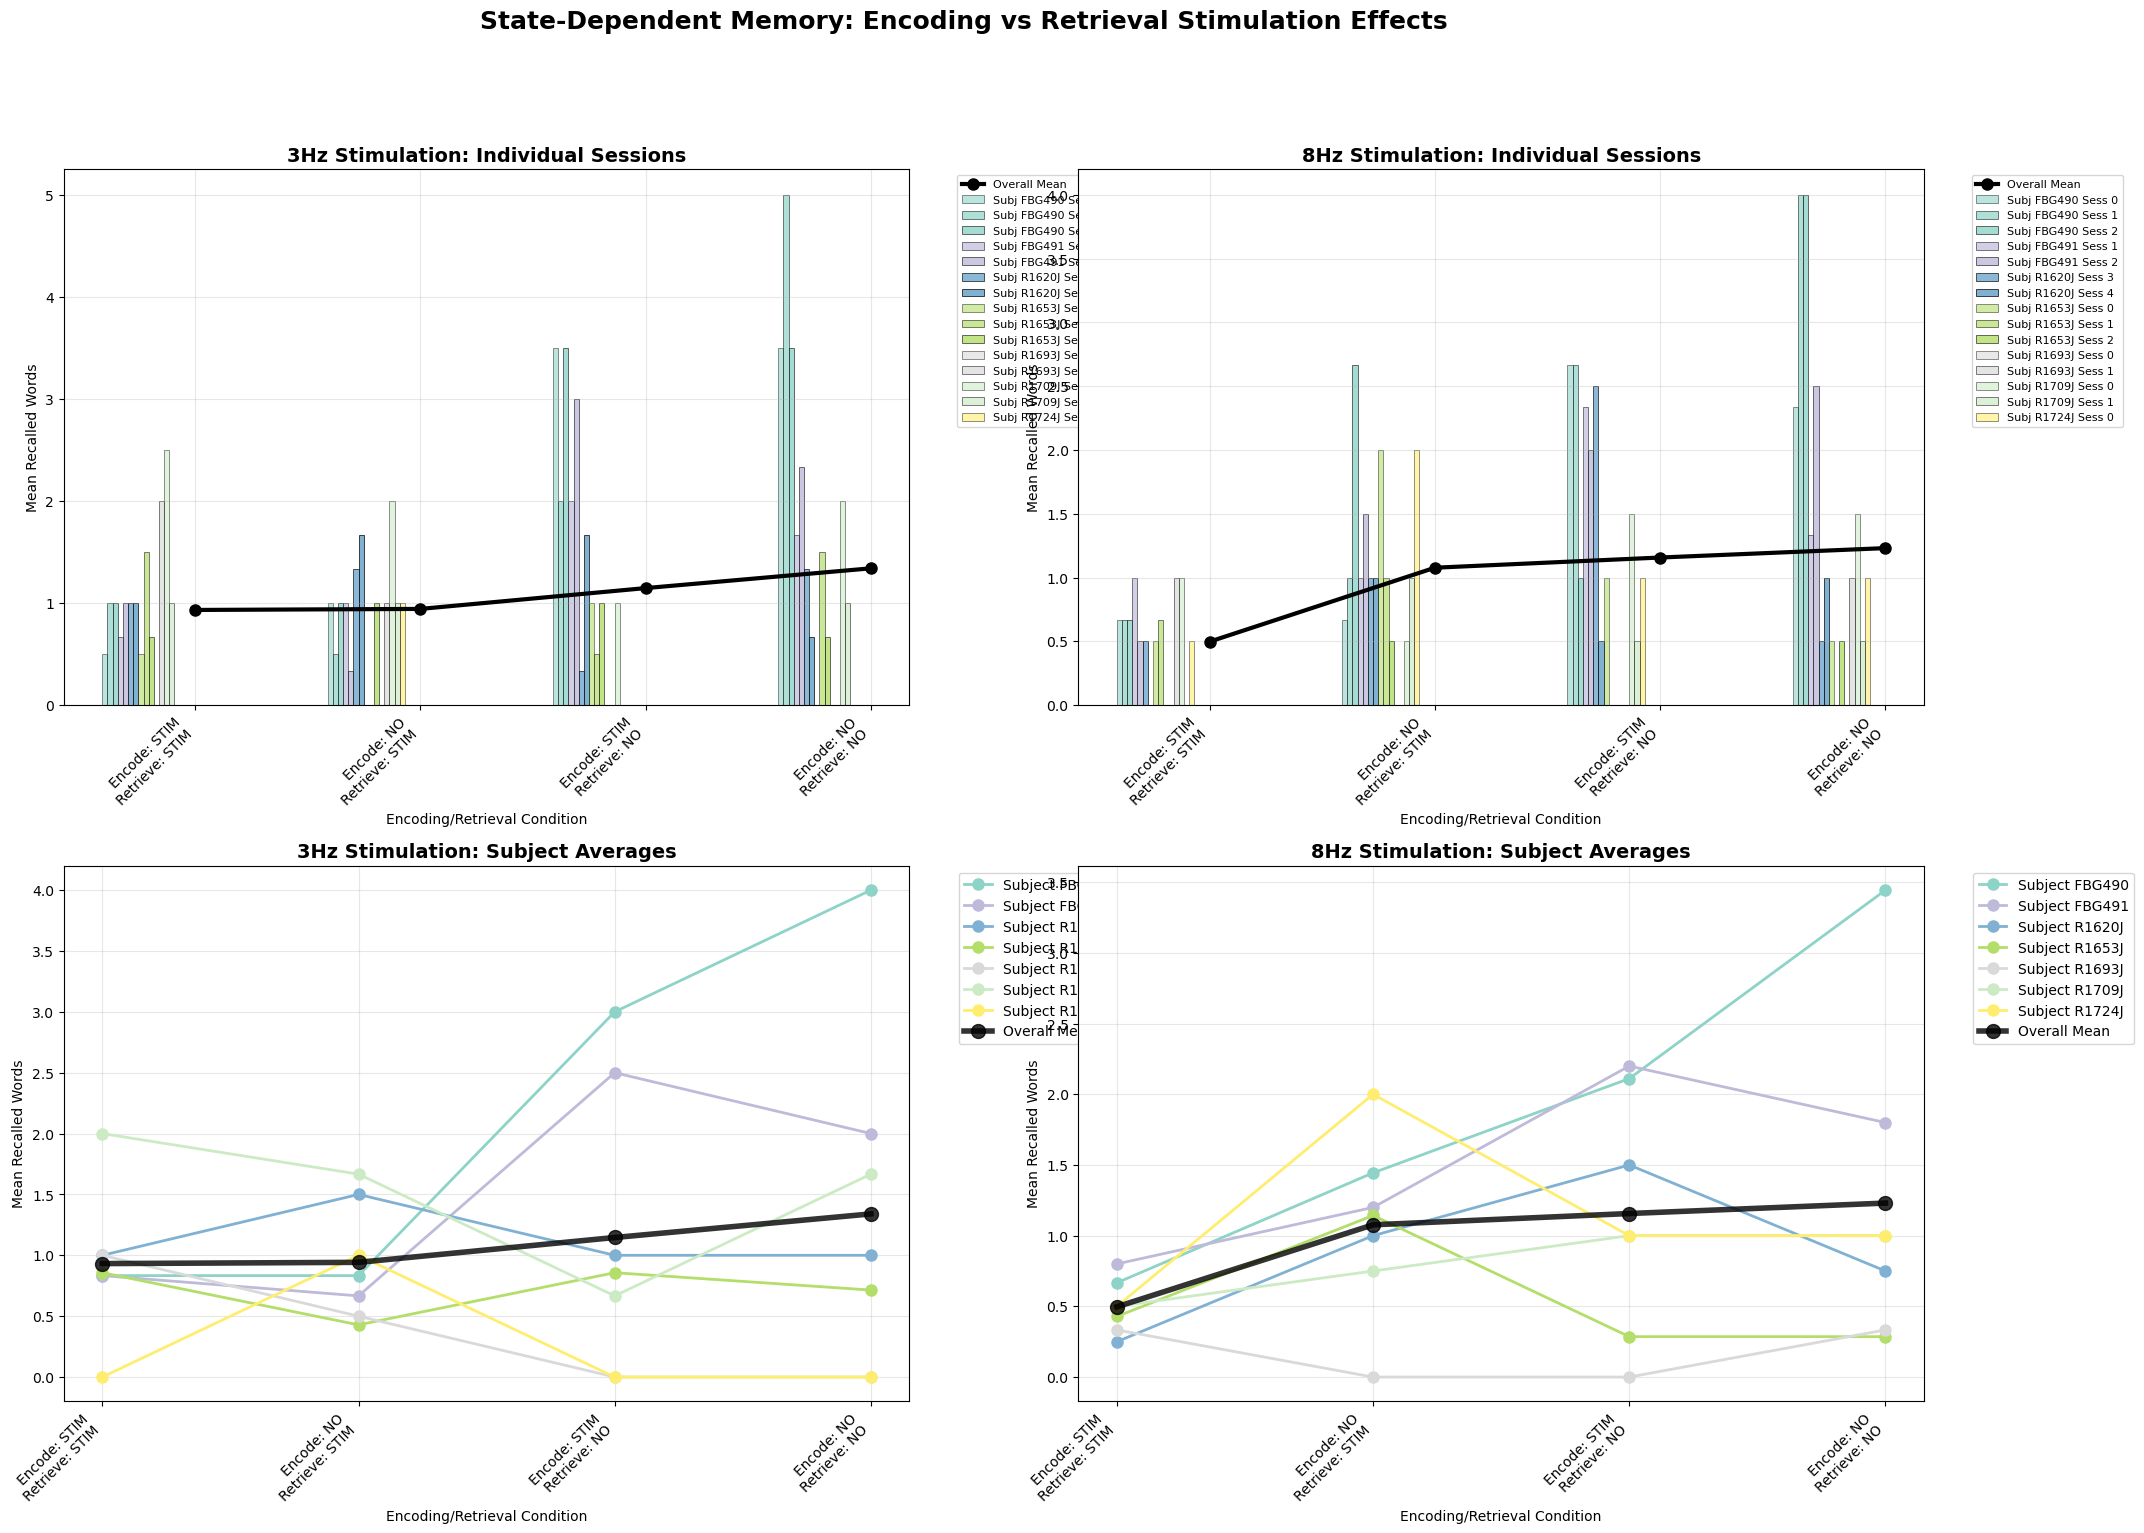

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_state_dependent_means(results_df):
    """Calculate subject-level and session-level means for state-dependent memory analysis"""
    
    # Define the columns for each stimulation frequency and encoding/retrieval combination
    state_columns_3hz = [
        'encode_STIM_retrival_STIM_3hz',  # Encoded WITH stim, Retrieved WITH 3Hz stim
        'encode_No_retrival_STIM_3hz',    # Encoded WITHOUT stim, Retrieved WITH 3Hz stim  
        'encode_STIM_retrival_No_3hz',    # Encoded WITH stim, Retrieved WITHOUT stim (when 3Hz present)
        'encode_No_retrival_No_3hz'       # Encoded WITHOUT stim, Retrieved WITHOUT stim (when 3Hz present)
    ]
    
    state_columns_8hz = [
        'encode_STIM_retrival_STIM_8hz',  # Encoded WITH stim, Retrieved WITH 8Hz stim
        'encode_No_retrival_STIM_8hz',    # Encoded WITHOUT stim, Retrieved WITH 8Hz stim
        'encode_STIM_retrival_No_8hz',    # Encoded WITH stim, Retrieved WITHOUT stim (when 8Hz present)  
        'encode_No_retrival_No_8hz'       # Encoded WITHOUT stim, Retrieved WITHOUT stim (when 8Hz present)
    ]
    
    # Calculate subject-level means (original functionality)
    subject_state_means = results_df.groupby('subject').agg({
        **{col: 'mean' for col in state_columns_3hz},
        **{col: 'mean' for col in state_columns_8hz}
    }).reset_index()
    
    # Calculate subject x session level means (new functionality)
    session_state_means = None
    if 'session' in results_df.columns:
        session_state_means = results_df.groupby(['subject', 'session']).agg({
            **{col: 'mean' for col in state_columns_3hz},
            **{col: 'mean' for col in state_columns_8hz}
        }).reset_index()
    
    return subject_state_means, session_state_means

def plot_state_dependent_analysis_with_sessions(subject_state_means, session_state_means=None):
    """Create comprehensive state-dependent memory visualization including sessions"""
    
    # Determine figure layout based on whether we have session data
    if session_state_means is not None:
        fig = plt.figure(figsize=(24, 16))
        # Create a 2x2 grid: top row for individual sessions, bottom row for subject averages
        gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.3, wspace=0.2)
        ax1 = fig.add_subplot(gs[0, 0])  # Individual sessions 3Hz
        ax2 = fig.add_subplot(gs[0, 1])  # Individual sessions 8Hz
        ax3 = fig.add_subplot(gs[1, 0])  # Subject averages 3Hz
        ax4 = fig.add_subplot(gs[1, 1])  # Subject averages 8Hz
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    fig.suptitle('State-Dependent Memory: Encoding vs Retrieval Stimulation Effects', 
                 fontsize=18, fontweight='bold')
    
    subjects = subject_state_means['subject'].unique()
    n_subjects = len(subjects)
    
    # Create color palette for subjects
    subject_colors = plt.cm.Set3(np.linspace(0, 1, n_subjects))
    subject_color_map = {subject: subject_colors[i] for i, subject in enumerate(subjects)}
    
    # Define conditions and labels
    conditions_3hz = ['encode_STIM_retrival_STIM_3hz', 'encode_No_retrival_STIM_3hz', 
                      'encode_STIM_retrival_No_3hz', 'encode_No_retrival_No_3hz']
    conditions_8hz = ['encode_STIM_retrival_STIM_8hz', 'encode_No_retrival_STIM_8hz',
                      'encode_STIM_retrival_No_8hz', 'encode_No_retrival_No_8hz']
    
    condition_labels = ['Encode: STIM\nRetrieve: STIM', 'Encode: NO\nRetrieve: STIM',
                       'Encode: STIM\nRetrieve: NO', 'Encode: NO\nRetrieve: NO']
    
    x_positions = np.arange(len(conditions_3hz))
    
    # If we have session data, create session-based bar plots for plots 1&2
    if session_state_means is not None:
        sessions = session_state_means['session'].unique()
        n_sessions = len(sessions)
        total_bars = n_subjects * n_sessions
        width = 0.8 / total_bars
        
        # Plot 1: 3Hz Condition - Individual Sessions as Bars
        bar_index = 0
        for i, subject in enumerate(subjects):
            subject_sessions = session_state_means[session_state_means['subject'] == subject]
            for j, session in enumerate(sessions):
                session_data = subject_sessions[subject_sessions['session'] == session]
                if not session_data.empty:
                    values_3hz = [session_data[col].iloc[0] if not pd.isna(session_data[col].iloc[0]) else 0 
                                  for col in conditions_3hz]
                    
                    # Create bars for each session
                    bars = ax1.bar(x_positions + (bar_index - total_bars/2) * width, values_3hz,
                                  width, label=f'Subj {subject} Sess {session}', 
                                  color=subject_color_map[subject], 
                                  alpha=0.6 + 0.1*j, edgecolor='black', linewidth=0.5)
                    bar_index += 1
        
        # Add overall mean line for 3Hz
        overall_means_3hz = [subject_state_means[col].mean() for col in conditions_3hz]
        ax1.plot(x_positions, overall_means_3hz, 'ko-', linewidth=3, markersize=8, label='Overall Mean')
        
        ax1.set_title('3Hz Stimulation: Individual Sessions', fontweight='bold', fontsize=14)
        ax1.set_ylabel('Mean Recalled Words')
        ax1.set_xlabel('Encoding/Retrieval Condition')
        ax1.set_xticks(x_positions)
        ax1.set_xticklabels(condition_labels, rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        
        # Plot 2: 8Hz Condition - Individual Sessions as Bars
        bar_index = 0
        for i, subject in enumerate(subjects):
            subject_sessions = session_state_means[session_state_means['subject'] == subject]
            for j, session in enumerate(sessions):
                session_data = subject_sessions[subject_sessions['session'] == session]
                if not session_data.empty:
                    values_8hz = [session_data[col].iloc[0] if not pd.isna(session_data[col].iloc[0]) else 0 
                                  for col in conditions_8hz]
                    
                    # Create bars for each session
                    bars = ax2.bar(x_positions + (bar_index - total_bars/2) * width, values_8hz,
                                  width, label=f'Subj {subject} Sess {session}', 
                                  color=subject_color_map[subject], 
                                  alpha=0.6 + 0.1*j, edgecolor='black', linewidth=0.5)
                    bar_index += 1
        
        # Add overall mean line for 8Hz
        overall_means_8hz = [subject_state_means[col].mean() for col in conditions_8hz]
        ax2.plot(x_positions, overall_means_8hz, 'ko-', linewidth=3, markersize=8, label='Overall Mean')
        
        ax2.set_title('8Hz Stimulation: Individual Sessions', fontweight='bold', fontsize=14)
        ax2.set_ylabel('Mean Recalled Words')
        ax2.set_xlabel('Encoding/Retrieval Condition')
        ax2.set_xticks(x_positions)
        ax2.set_xticklabels(condition_labels, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        
        # Plot 3: 3Hz Condition - Subject Averages as Lines
        for i, subject in enumerate(subjects):
            subject_data = subject_state_means[subject_state_means['subject'] == subject]
            values_3hz = [subject_data[col].iloc[0] if not pd.isna(subject_data[col].iloc[0]) else 0 
                          for col in conditions_3hz]
            
            # Plot subject average as a line
            ax3.plot(x_positions, values_3hz, 'o-', linewidth=2, markersize=8,
                    color=subject_color_map[subject], label=f'Subject {subject}')
        
        # Add overall mean line for 3Hz
        ax3.plot(x_positions, overall_means_3hz, 'ko-', linewidth=4, markersize=10, 
                label='Overall Mean', alpha=0.8)
        
        ax3.set_title('3Hz Stimulation: Subject Averages', fontweight='bold', fontsize=14)
        ax3.set_ylabel('Mean Recalled Words')
        ax3.set_xlabel('Encoding/Retrieval Condition')
        ax3.set_xticks(x_positions)
        ax3.set_xticklabels(condition_labels, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3)
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot 4: 8Hz Condition - Subject Averages as Lines
        for i, subject in enumerate(subjects):
            subject_data = subject_state_means[subject_state_means['subject'] == subject]
            values_8hz = [subject_data[col].iloc[0] if not pd.isna(subject_data[col].iloc[0]) else 0 
                          for col in conditions_8hz]
            
            # Plot subject average as a line
            ax4.plot(x_positions, values_8hz, 'o-', linewidth=2, markersize=8,
                    color=subject_color_map[subject], label=f'Subject {subject}')
        
        # Add overall mean line for 8Hz
        ax4.plot(x_positions, overall_means_8hz, 'ko-', linewidth=4, markersize=10, 
                label='Overall Mean', alpha=0.8)
        
        ax4.set_title('8Hz Stimulation: Subject Averages', fontweight='bold', fontsize=14)
        ax4.set_ylabel('Mean Recalled Words')
        ax4.set_xlabel('Encoding/Retrieval Condition')
        ax4.set_xticks(x_positions)
        ax4.set_xticklabels(condition_labels, rotation=45, ha='right')
        ax4.grid(True, alpha=0.3)
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    else:
        # Original plotting for when no session data is available
        width = 0.8 / (n_subjects + 1)
        
        # Plot 1: 3Hz Condition - Subject Means
        for i, subject in enumerate(subjects):
            subject_data = subject_state_means[subject_state_means['subject'] == subject]
            values_3hz = [subject_data[col].iloc[0] if not pd.isna(subject_data[col].iloc[0]) else 0 
                          for col in conditions_3hz]
            
            bars = ax1.bar(x_positions + (i - n_subjects/2) * width, values_3hz,
                          width, label=f'Subject {subject}', color=subject_colors[i], 
                          alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Add overall mean line for 3Hz
        overall_means_3hz = [subject_state_means[col].mean() for col in conditions_3hz]
        ax1.plot(x_positions, overall_means_3hz, 'ko-', linewidth=3, markersize=8, label='Overall Mean')
        
        ax1.set_title('3Hz Stimulation: Subject-Level Means', fontweight='bold', fontsize=14)
        ax1.set_ylabel('Mean Recalled Words')
        ax1.set_xlabel('Encoding/Retrieval Condition')
        ax1.set_xticks(x_positions)
        ax1.set_xticklabels(condition_labels, rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot 2: 8Hz Condition - Subject Means
        for i, subject in enumerate(subjects):
            subject_data = subject_state_means[subject_state_means['subject'] == subject]
            values_8hz = [subject_data[col].iloc[0] if not pd.isna(subject_data[col].iloc[0]) else 0 
                          for col in conditions_8hz]
            
            bars = ax2.bar(x_positions + (i - n_subjects/2) * width, values_8hz,
                          width, label=f'Subject {subject}', color=subject_colors[i], 
                          alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Add overall mean line for 8Hz
        overall_means_8hz = [subject_state_means[col].mean() for col in conditions_8hz]
        ax2.plot(x_positions, overall_means_8hz, 'ko-', linewidth=3, markersize=8, label='Overall Mean')
        
        ax2.set_title('8Hz Stimulation: Subject-Level Means', fontweight='bold', fontsize=14)
        ax2.set_ylabel('Mean Recalled Words')
        ax2.set_xlabel('Encoding/Retrieval Condition')
        ax2.set_xticks(x_positions)
        ax2.set_xticklabels(condition_labels, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    return fig, (overall_means_3hz, overall_means_8hz)

def print_state_dependent_statistics_with_sessions(subject_state_means, session_state_means=None):
    """Print detailed statistics for state-dependent analysis including sessions"""
    
    print("\n" + "="*80)
    print("STATE-DEPENDENT MEMORY ANALYSIS")
    print("="*80)
    
    subjects = subject_state_means['subject'].unique()
    
    print("\n3Hz STIMULATION RESULTS:")
    print("-" * 40)
    print("Condition\t\t\t\tOverall Mean ± SD")
    
    conditions_3hz = {
        'encode_STIM_retrival_STIM_3hz': 'Encode: STIM, Retrieve: STIM',
        'encode_No_retrival_STIM_3hz': 'Encode: NO, Retrieve: STIM',
        'encode_STIM_retrival_No_3hz': 'Encode: STIM, Retrieve: NO', 
        'encode_No_retrival_No_3hz': 'Encode: NO, Retrieve: NO'
    }
    
    for col, label in conditions_3hz.items():
        mean_val = subject_state_means[col].mean()
        std_val = subject_state_means[col].std()
        print(f"{label:30s}\t{mean_val:.2f} ± {std_val:.2f}")
    
    print("\n8Hz STIMULATION RESULTS:")
    print("-" * 40)
    
    conditions_8hz = {
        'encode_STIM_retrival_STIM_8hz': 'Encode: STIM, Retrieve: STIM',
        'encode_No_retrival_STIM_8hz': 'Encode: NO, Retrieve: STIM',
        'encode_STIM_retrival_No_8hz': 'Encode: STIM, Retrieve: NO',
        'encode_No_retrival_No_8hz': 'Encode: NO, Retrieve: NO'
    }
    
    for col, label in conditions_8hz.items():
        mean_val = subject_state_means[col].mean()
        std_val = subject_state_means[col].std()
        print(f"{label:30s}\t{mean_val:.2f} ± {std_val:.2f}")
    
    print("\nSUBJECT-LEVEL BREAKDOWN:")
    print("-" * 40)
    
    for subject in subjects:
        subject_data = subject_state_means[subject_state_means['subject'] == subject]
        print(f"\nSubject {subject}:")
        print("  3Hz Conditions:")
        for col, label in conditions_3hz.items():
            val = subject_data[col].iloc[0]
            print(f"    {label:25s}: {val:.2f}" if not pd.isna(val) else f"    {label:25s}: N/A")
        
        print("  8Hz Conditions:")
        for col, label in conditions_8hz.items():
            val = subject_data[col].iloc[0]
            print(f"    {label:25s}: {val:.2f}" if not pd.isna(val) else f"    {label:25s}: N/A")
    
    # If session data is available, print session-level breakdown
    if session_state_means is not None:
        print("\n" + "="*80)
        print("SESSION-LEVEL BREAKDOWN:")
        print("="*80)
        
        sessions = session_state_means['session'].unique()
        
        for subject in subjects:
            print(f"\nSubject {subject} - Session Details:")
            print("-" * 50)
            subject_sessions = session_state_means[session_state_means['subject'] == subject]
            
            for session in sessions:
                session_data = subject_sessions[subject_sessions['session'] == session]
                if not session_data.empty:
                    print(f"\n  Session {session}:")
                    print("    3Hz Conditions:")
                    for col, label in conditions_3hz.items():
                        val = session_data[col].iloc[0]
                        print(f"      {label:20s}: {val:.2f}" if not pd.isna(val) else f"      {label:20s}: N/A")
                    
                    print("    8Hz Conditions:")
                    for col, label in conditions_8hz.items():
                        val = session_data[col].iloc[0]
                        print(f"      {label:20s}: {val:.2f}" if not pd.isna(val) else f"      {label:20s}: N/A")

def analyze_session_variability(session_state_means):
    """Analyze within-subject session variability"""
    
    if session_state_means is None:
        print("No session data available for variability analysis.")
        return
    
    print("\n" + "="*80)
    print("SESSION VARIABILITY ANALYSIS")
    print("="*80)
    
    conditions_all = [
        'encode_STIM_retrival_STIM_3hz', 'encode_No_retrival_STIM_3hz', 
        'encode_STIM_retrival_No_3hz', 'encode_No_retrival_No_3hz',
        'encode_STIM_retrival_STIM_8hz', 'encode_No_retrival_STIM_8hz',
        'encode_STIM_retrival_No_8hz', 'encode_No_retrival_No_8hz'
    ]
    
    subjects = session_state_means['subject'].unique()
    
    print("\nWithin-Subject Session Variability (Standard Deviation):")
    print("-" * 60)
    
    for subject in subjects:
        subject_data = session_state_means[session_state_means['subject'] == subject]
        print(f"\nSubject {subject}:")
        
        for condition in conditions_all:
            if condition in subject_data.columns:
                std_val = subject_data[condition].std()
                mean_val = subject_data[condition].mean()
                cv = (std_val / mean_val * 100) if mean_val != 0 else 0  # Coefficient of variation
                print(f"  {condition:30s}: SD={std_val:.2f}, CV={cv:.1f}%")

# Main execution function
def run_enhanced_state_dependent_analysis(results_df):
    """Main function to run the enhanced state-dependent analysis"""
    
    print("Starting Enhanced State-Dependent Memory Analysis...")
    
    # Check if session column exists
    has_sessions = 'session' in results_df.columns
    if has_sessions:
        print(f"Session data detected. Found {results_df['session'].nunique()} unique sessions.")
    else:
        print("No session column found. Analysis will be subject-level only.")
    
    # Calculate means
    subject_state_means, session_state_means = calculate_state_dependent_means(results_df)
    
    # Create visualizations
    fig, statistics = plot_state_dependent_analysis_with_sessions(subject_state_means, session_state_means)
    
    # Print statistics
    print_state_dependent_statistics_with_sessions(subject_state_means, session_state_means)
    
    # Analyze session variability if available
    if session_state_means is not None:
        analyze_session_variability(session_state_means)
    
    # Save results
    filename_suffix = "_with_sessions" if has_sessions else ""
    plt.savefig(f'state_dependent_memory_analysis{filename_suffix}.png', dpi=300, bbox_inches='tight')
    subject_state_means.to_csv(f'subject_state_dependent_means{filename_suffix}.csv', index=False)
    
    if session_state_means is not None:
        session_state_means.to_csv(f'session_state_dependent_means{filename_suffix}.csv', index=False)
    
    print(f"\nEnhanced state-dependent analysis complete!")
    print(f"Visualization saved as: state_dependent_memory_analysis{filename_suffix}.png")
    print(f"Subject data saved as: subject_state_dependent_means{filename_suffix}.csv")
    if session_state_means is not None:
        print(f"Session data saved as: session_state_dependent_means{filename_suffix}.csv")
    
    plt.show()
    
    return subject_state_means, session_state_means

# Main execution
if __name__ == "__main__":
    # Note: This assumes 'results_df' is available from the previous analysis
    # If running standalone, you would need to load the data first
    
    subject_means, session_means = run_enhanced_state_dependent_analysis(results_df)